<a href="https://colab.research.google.com/github/amhen/ML_perm/blob/main/both_binary_models_and_test_compounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
#conda_installer.install()
!/root/miniconda/bin/conda info -e
!pip install rdkit-pypi
!pip install --pre deepchem
import deepchem
deepchem.__version__
#creating machine learning df 
import deepchem as dc
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

!pip install wandb --upgrade
import wandb

from deepchem.models.wandblogger import WandbLogger
from deepchem.models.callbacks import ValidationCallback
from rdkit import Chem
from rdkit import RDConfig
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.pipeline import Pipeline
from keras.callbacks import TensorBoard
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
import tempfile
import shutil
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow.keras.layers as layers
from deepchem.feat.mol_graphs import ConvMol
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit import rdBase
from deepchem import metrics
from IPython.display import Image, display
from rdkit.Chem.Draw import SimilarityMaps
import tensorflow as tf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3457  100  3457    0     0  67784      0 --:--:-- --:--:-- --:--:-- 67784
/bin/bash: /root/miniconda/bin/conda: No such file or directory
     |████████████████████████████████| 22.7 MB 1.7 MB/s 
     |████████████████████████████████| 608 kB 5.0 MB/s 
     |████████████████████████████████| 1.8 MB 4.5 MB/s 
     |████████████████████████████████| 144 kB 29.1 MB/s 
     |████████████████████████████████| 181 kB 51.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=a6f42e589e66c47269a7dded29d25b49bc88b5c6bd6967d950582a848e25e952
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
#mdf.to_csv('mdf1.csv')
#ecfp = circular fingerprint

wandb.init()
featurizer = dc.feat.CircularFingerprint(size=1024,radius=3)
n_features = 1024
tasks=["class_1"]
wandblogger = WandbLogger(project='PP_rf', entity='ahenperm')

from deepchem.utils.save import load_from_disk
dataset_file= "/content/mdf2 - mdf2.csv"
dataset = load_from_disk(dataset_file)

loader = dc.data.CSVLoader(
      tasks=["class_1"], feature_field="SMILES",
      featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

splitter = dc.splits.RandomStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset,seed=3)
transformers = [
    dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)
  
from sklearn.ensemble import RandomForestClassifier
sklearn_model = RandomForestClassifier(n_estimators=100,max_features='auto' )
modelrf = dc.models.SklearnModel(sklearn_model)

metric = dc.metrics.Metric(dc.metrics.roc_auc_score , np.mean,mode='classification')

modelrf.fit(train_dataset)
print('training set score:', modelrf.evaluate(train_dataset, [metric]))
print('test set score:', modelrf.evaluate(test_dataset, [metric]))
print('valid set score:', modelrf.evaluate(valid_dataset, [metric]))



#wandb.finish()

training set score: {'mean-roc_auc_score': 0.9996225932322651}
test set score: {'mean-roc_auc_score': 0.8608}
valid set score: {'mean-roc_auc_score': 0.8058000000000001}


In [ ]:
test_preds_0 = modelrf.predict(test_dataset)
test_preds_0.shape
y_test =test_dataset.y 

y_test =test_dataset.y 
y_probas = test_preds_0
#Precision Recall
wandb.log({'precision recall of rf model': wandb.plots.precision_recall(y_test, y_probas)})
wandb.log({'ROC of RF': wandb.plots.ROC(y_test, y_probas)})
#confusion matrix
b = np.argmax(y_probas,axis=-1)
y_true_0 = test_dataset.y
# Confusion Matrix
wandb.sklearn.plot_confusion_matrix( y_true_0, b)
wandb.finish()

wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


# Random Forest Results:

training set score: {'mean-roc_auc_score': 0.9996225932322651}

test set score: {'mean-roc_auc_score': 0.8608}

valid set score: {'mean-roc_auc_score': 0.8058000000000001}



**Confusion Matrix**
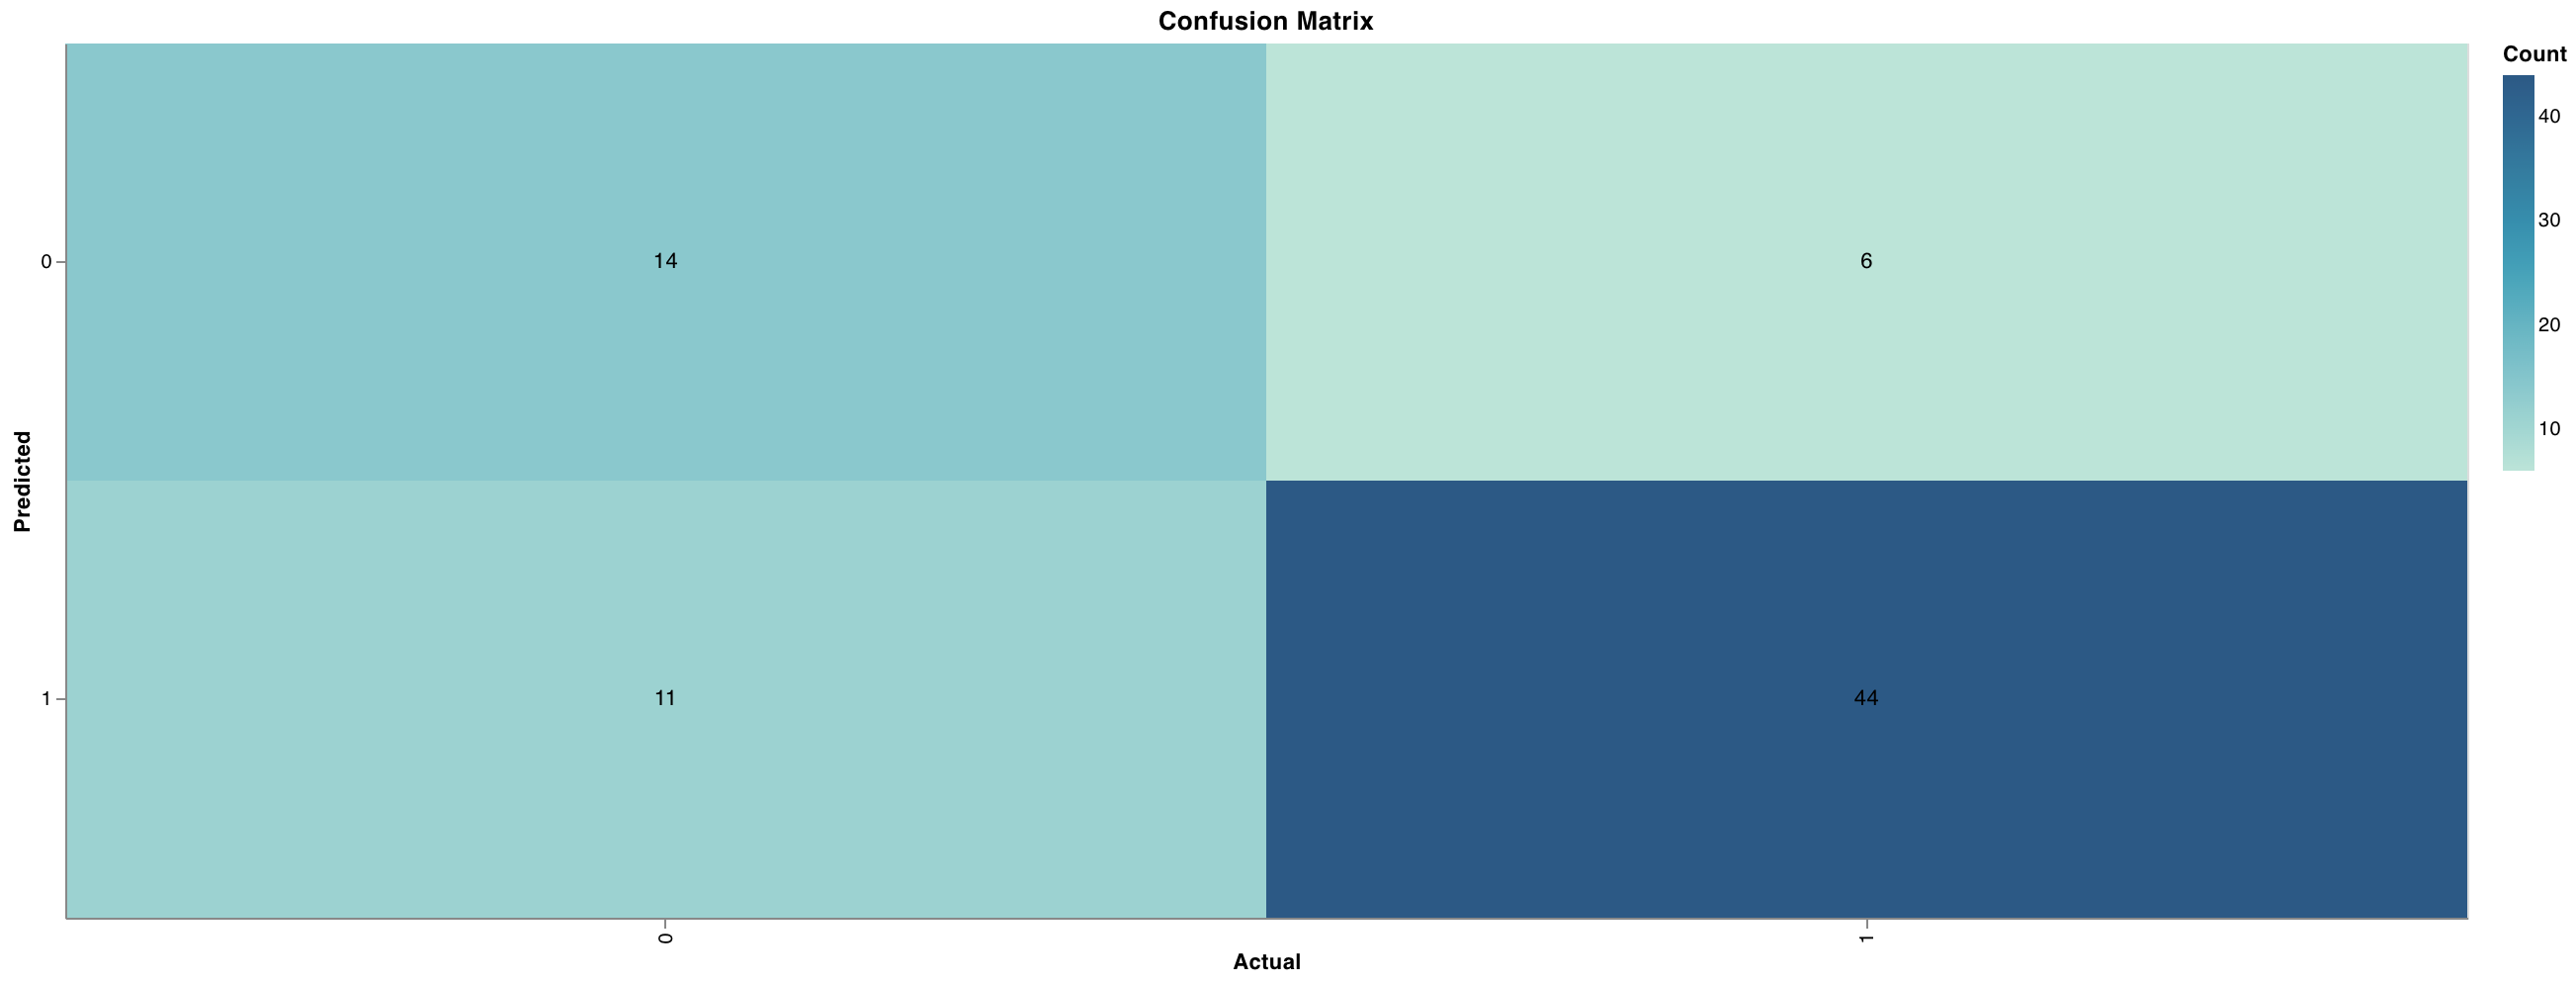

Precision/Recall
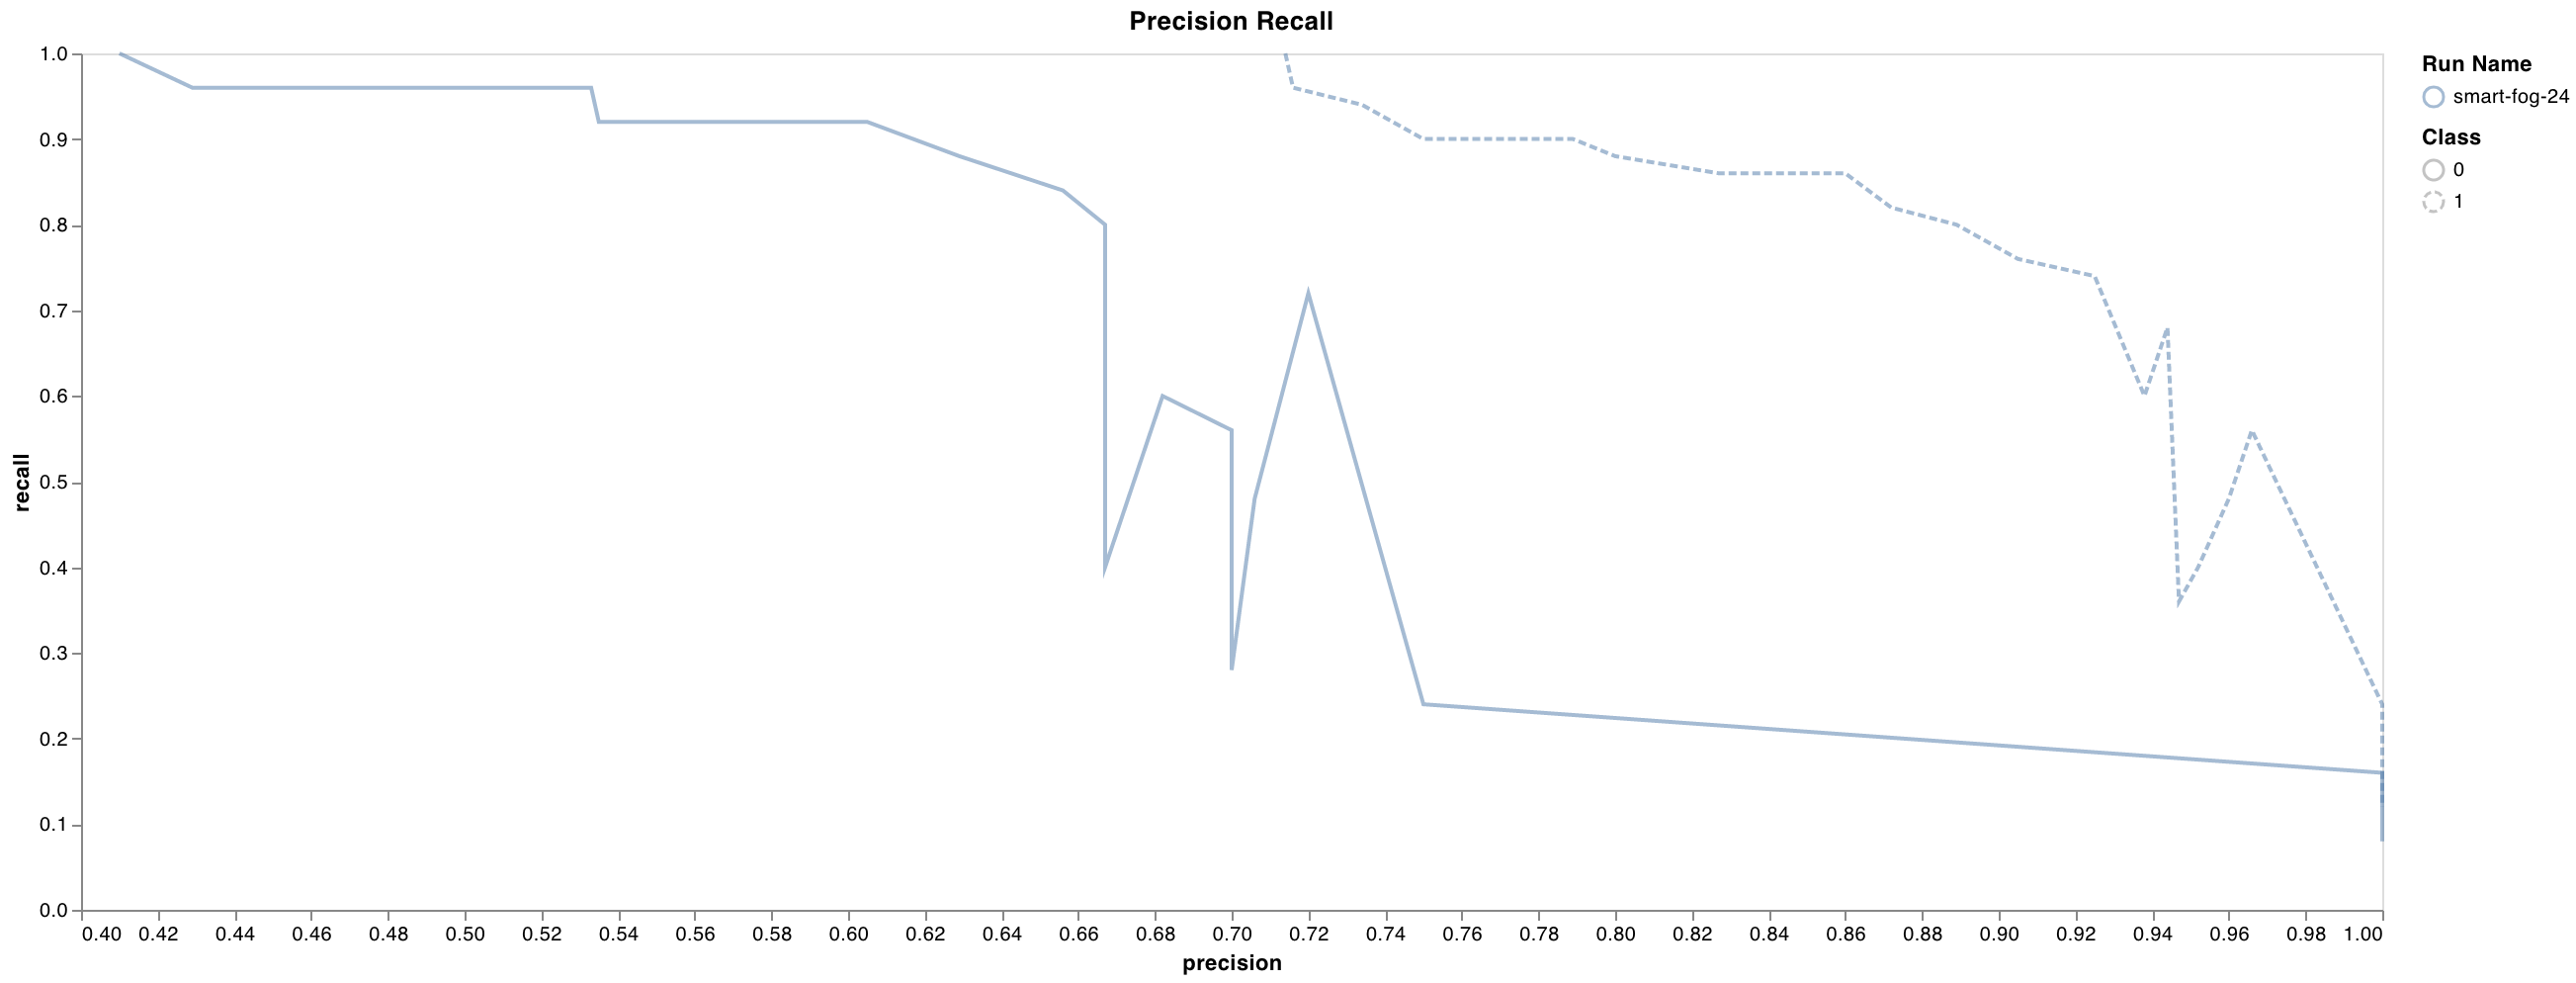

ROC curve
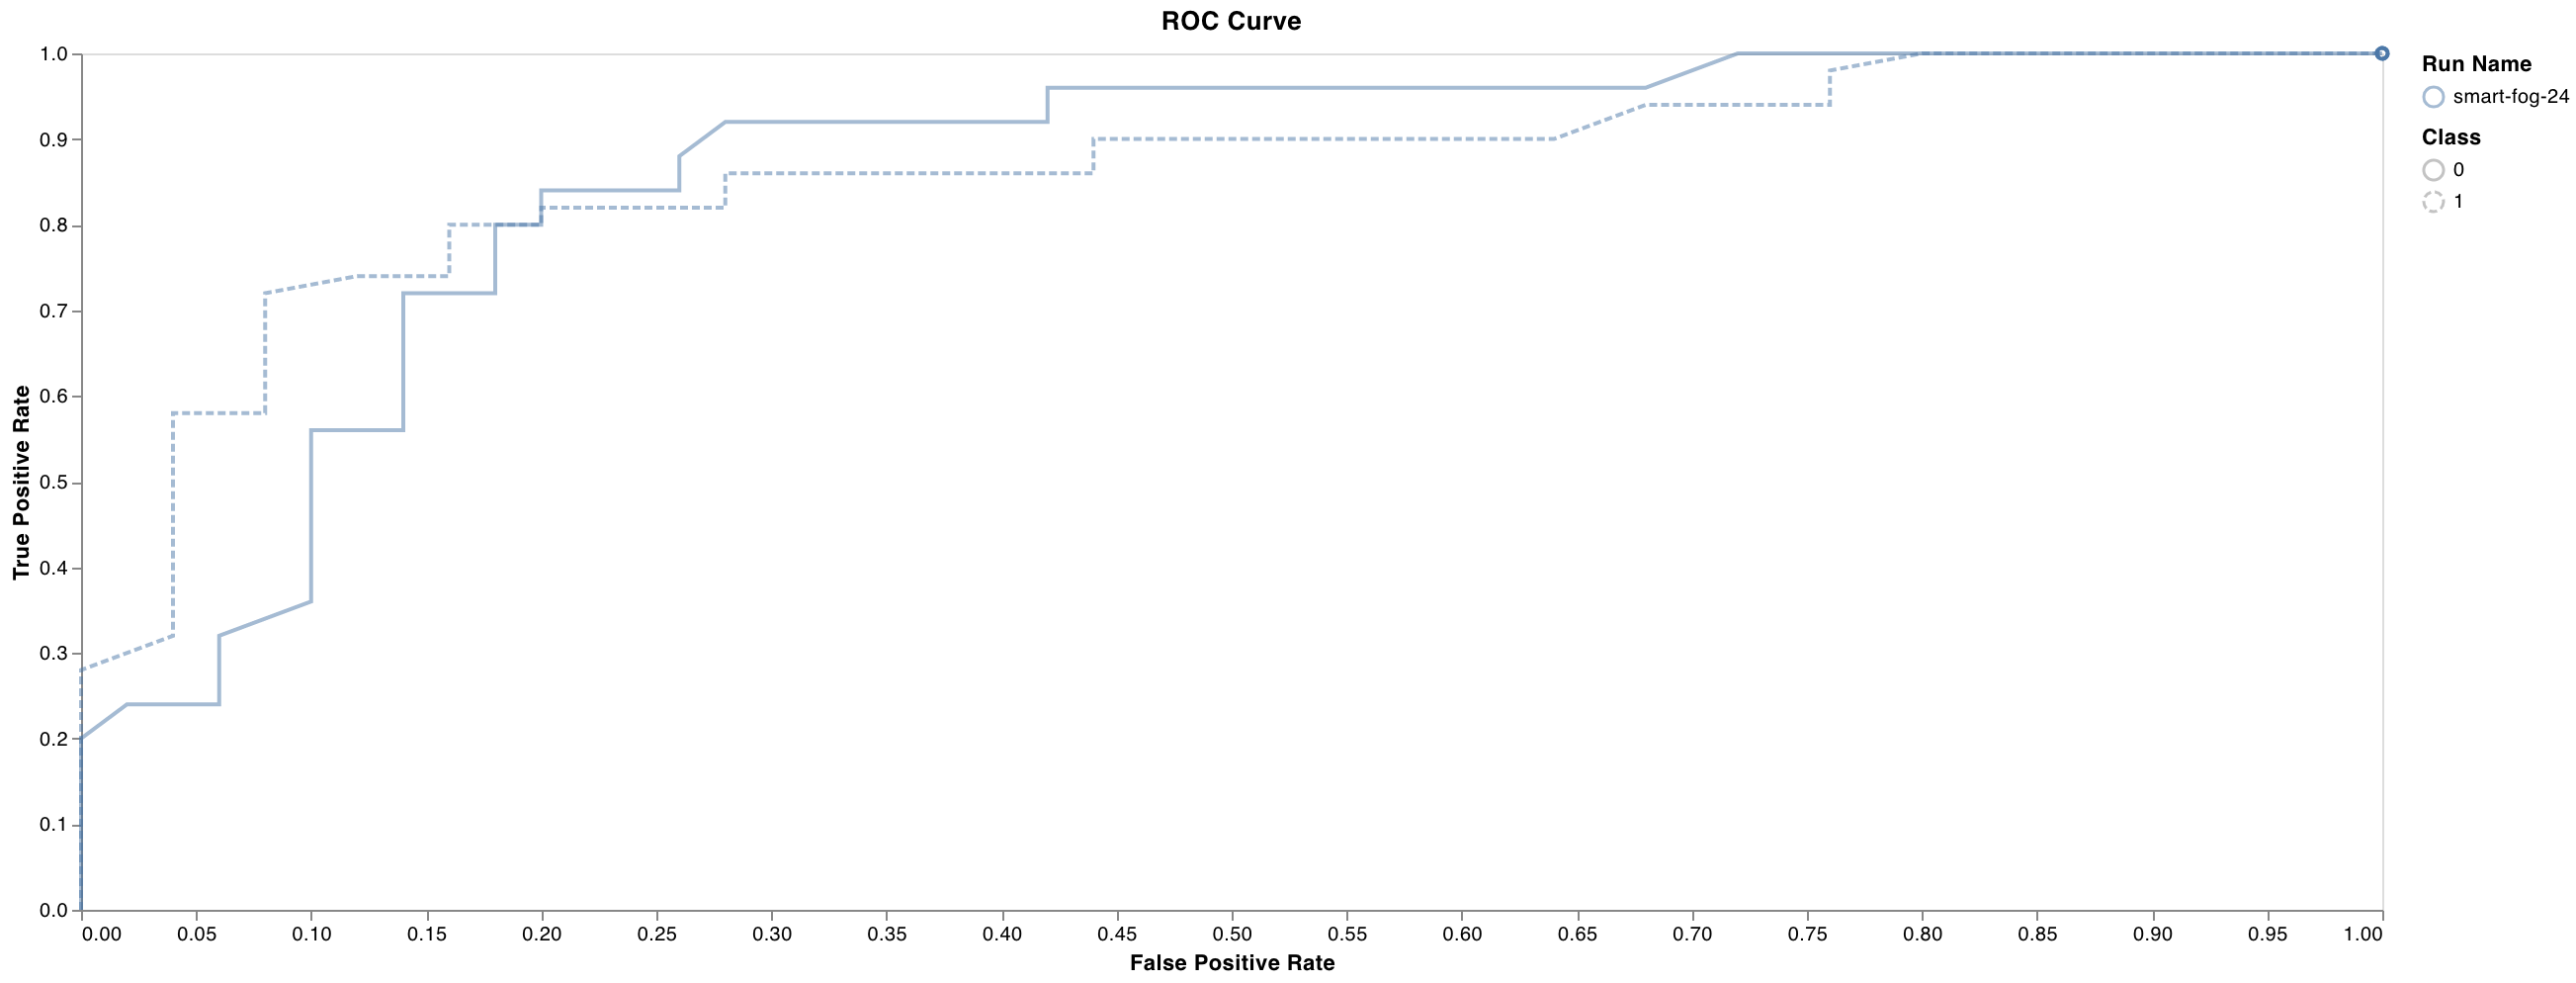

In [ ]:
wandb.init()
wandblogger = WandbLogger(project='PP_GCN_B', entity='ahenperm')

featurizer = dc.feat.ConvMolFeaturizer()
from deepchem.utils.save import load_from_disk
dataset_file= "/content/mdf2 - mdf2.csv"
dataset = load_from_disk(dataset_file)


loader = dc.data.CSVLoader(
      tasks=["class_0","class_1"], feature_field="SMILES",
      featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset,seed=3)
transformers = []

tasks=["class_0","class_1"]
model_dir =  "/content/gdrive/My Drive/{dc_gcn_perm_4}"

batch_size = 11

model = dc.models.GraphConvModel(
    len(tasks),
    dropout=0.1,
    batch_size=batch_size,
    batch_normalize=True,
    mode='classification',
    model_dir=model_dir,
    wandb_logger=wandblogger
    )

metric = dc.metrics.Metric(dc.metrics.roc_auc_score , np.mean,mode='classification')
vc_valid = ValidationCallback(valid_dataset, interval=10, metrics=[metric])
model.fit(train_dataset, nb_epoch=30,callbacks=vc_valid)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/Reshape_14:0", shape=(76,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/Reshape_13:0", shape=(76, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/Reshape_17:0", shape=(190,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/Res

Step 10 validation: mean-roc_auc_score=0.57446
Step 20 validation: mean-roc_auc_score=0.596836
Step 30 validation: mean-roc_auc_score=0.605324
Step 40 validation: mean-roc_auc_score=0.561728
Step 50 validation: mean-roc_auc_score=0.607639
Step 60 validation: mean-roc_auc_score=0.684414
Step 70 validation: mean-roc_auc_score=0.664352
Step 80 validation: mean-roc_auc_score=0.663194
Step 90 validation: mean-roc_auc_score=0.643904
Step 100 validation: mean-roc_auc_score=0.70679
Step 110 validation: mean-roc_auc_score=0.6875
Step 120 validation: mean-roc_auc_score=0.68017
Step 130 validation: mean-roc_auc_score=0.673997
Step 140 validation: mean-roc_auc_score=0.694059
Step 150 validation: mean-roc_auc_score=0.709877
Step 160 validation: mean-roc_auc_score=0.703704
Step 170 validation: mean-roc_auc_score=0.712191
Step 180 validation: mean-roc_auc_score=0.713735
Step 190 validation: mean-roc_auc_score=0.725694
Step 200 validation: mean-roc_auc_score=0.729167
Step 210 validation: mean-roc_auc_

0.4091647720336914

In [ ]:
print('training set score:', model.evaluate(train_dataset, [metric],transformers))
print('test set score:', model.evaluate(test_dataset, [metric], transformers))
print('valid set score:', model.evaluate(valid_dataset, [metric], transformers))

training set score: {'mean-roc_auc_score': 0.9195643059855522}
test set score: {'mean-roc_auc_score': 0.7629513343799058}
valid set score: {'mean-roc_auc_score': 0.8445216049382716}


In [ ]:
wandb.finish()

# Results of binary GCN one-hot encoded

training set score: {'mean-roc_auc_score': 0.9195643059855522}

test set score: {'mean-roc_auc_score': 0.7629513343799058}

valid set score: {'mean-roc_auc_score': 0.8445216049382716}

Run summary:
- eval/mean-roc_auc_score_(0)	0.84452
- train/loss	0.34129

training/loss
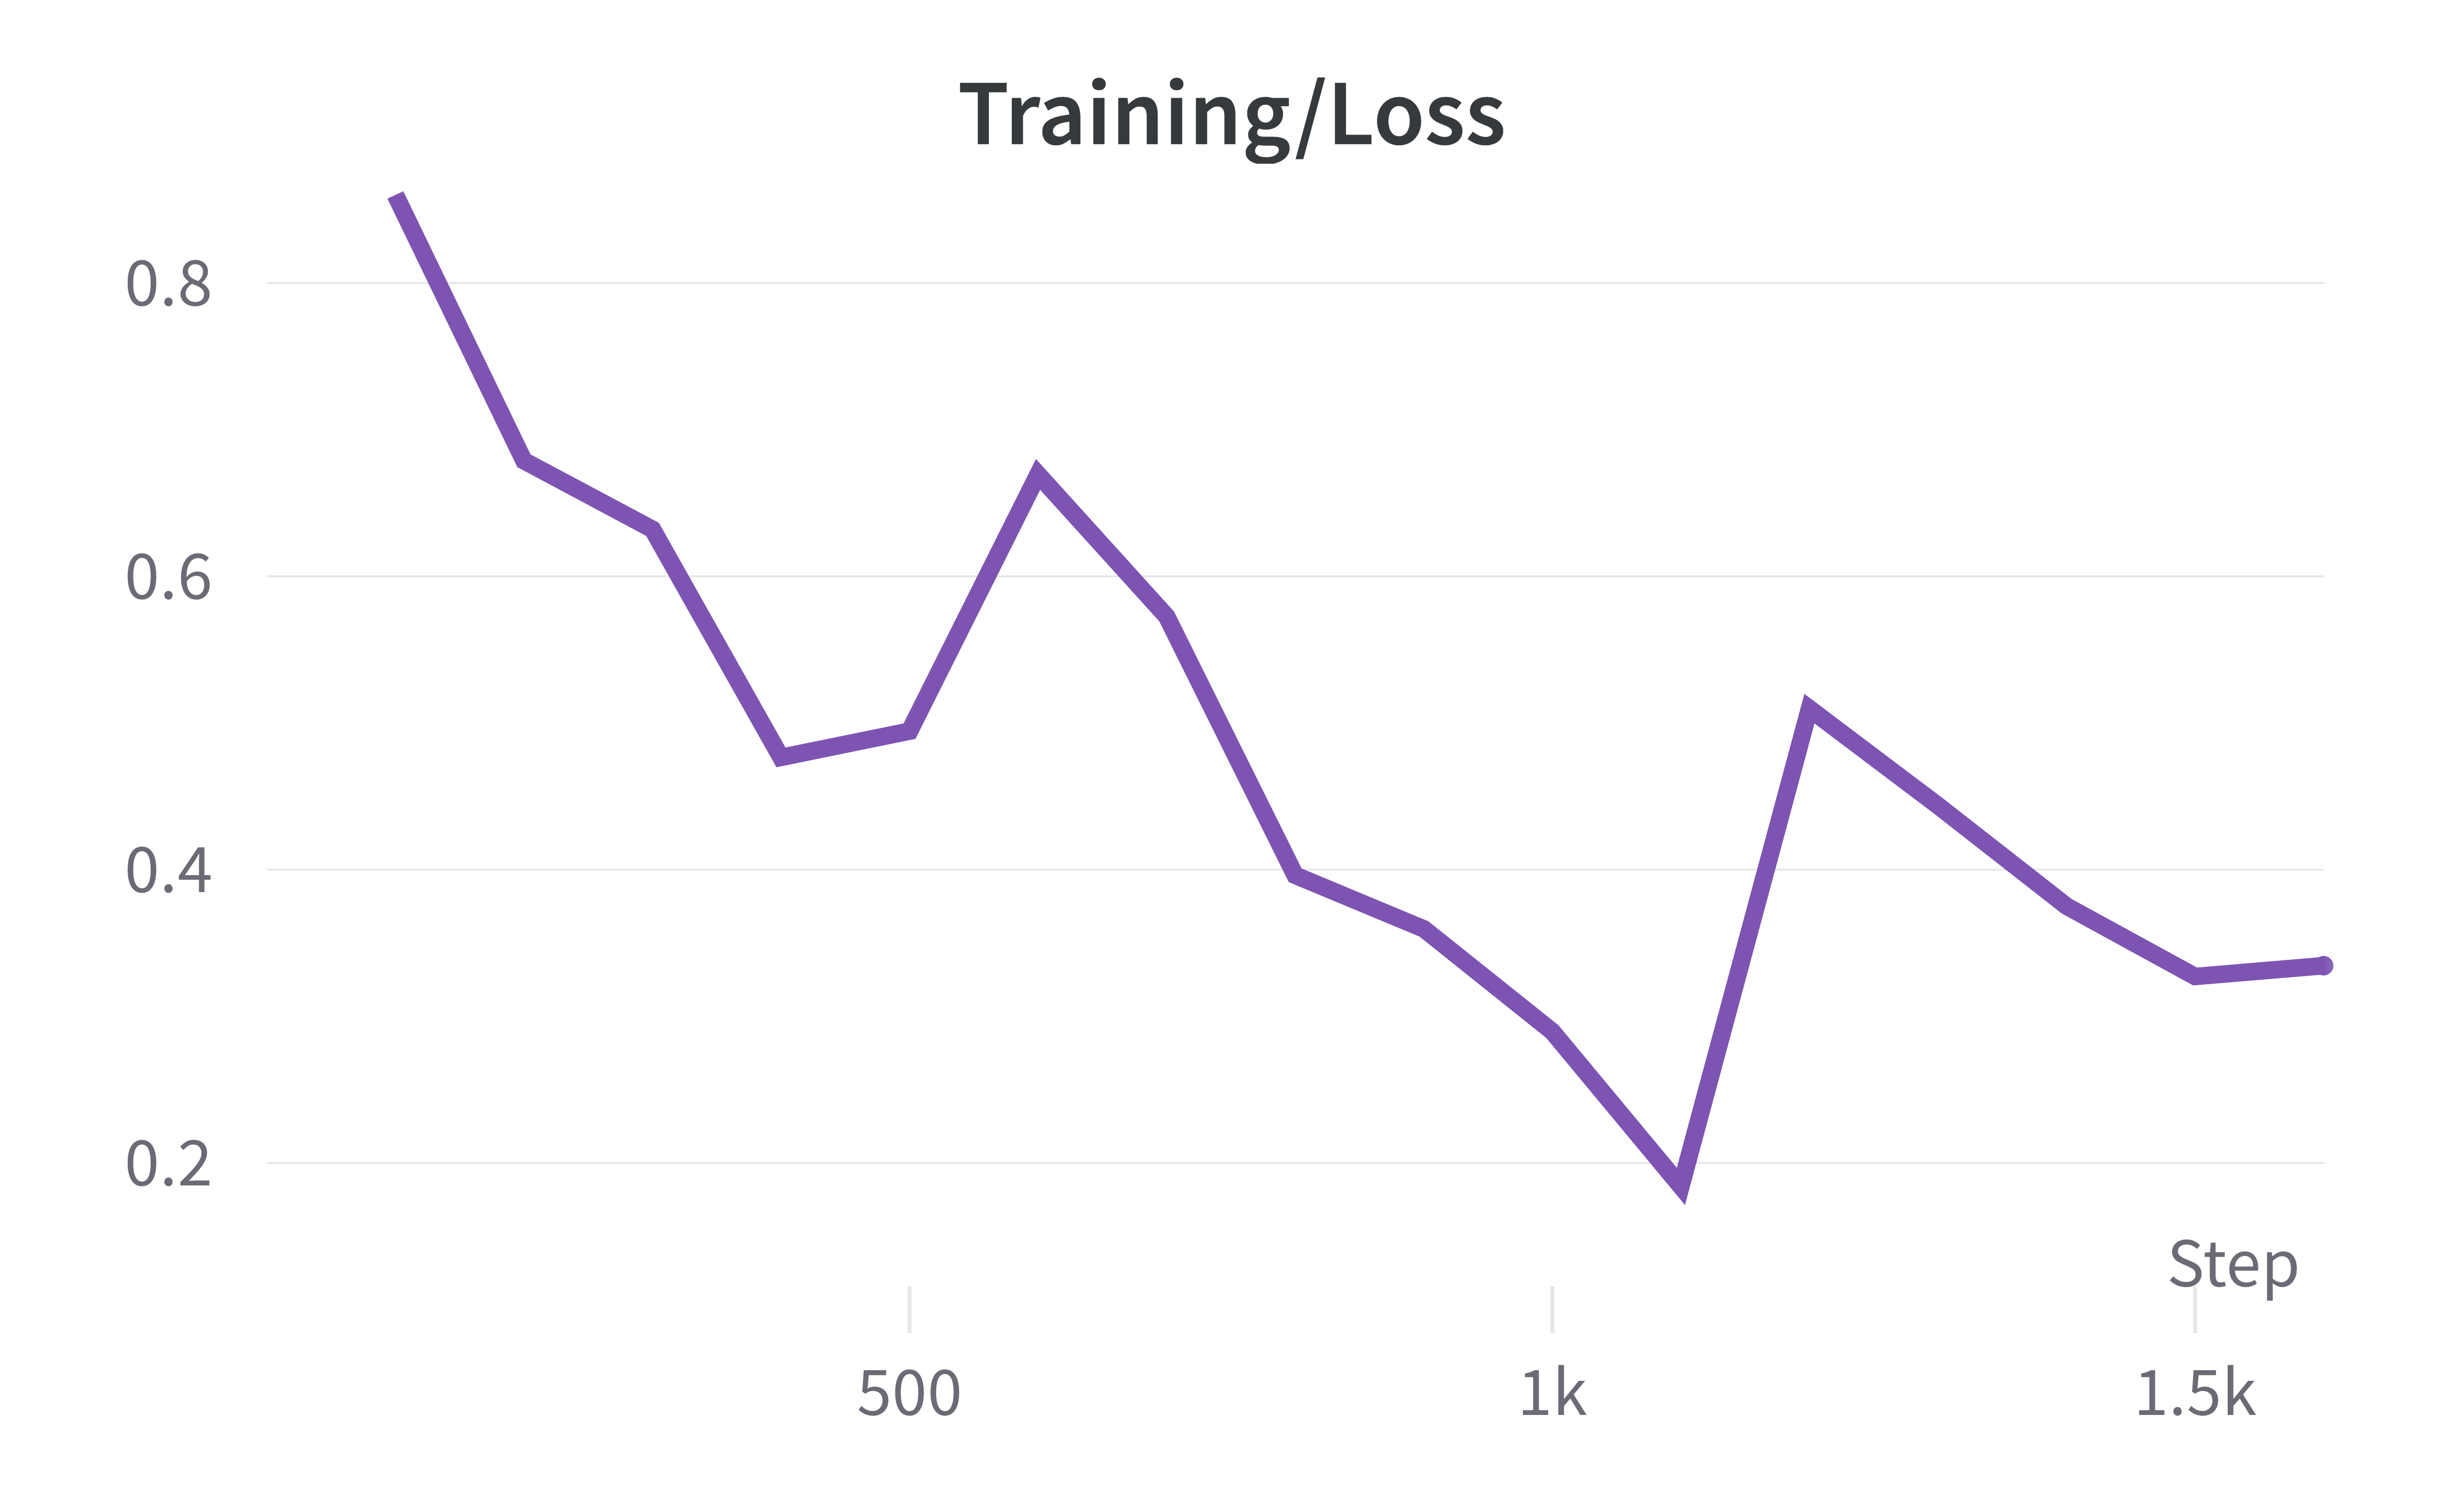
mean roc auc curve
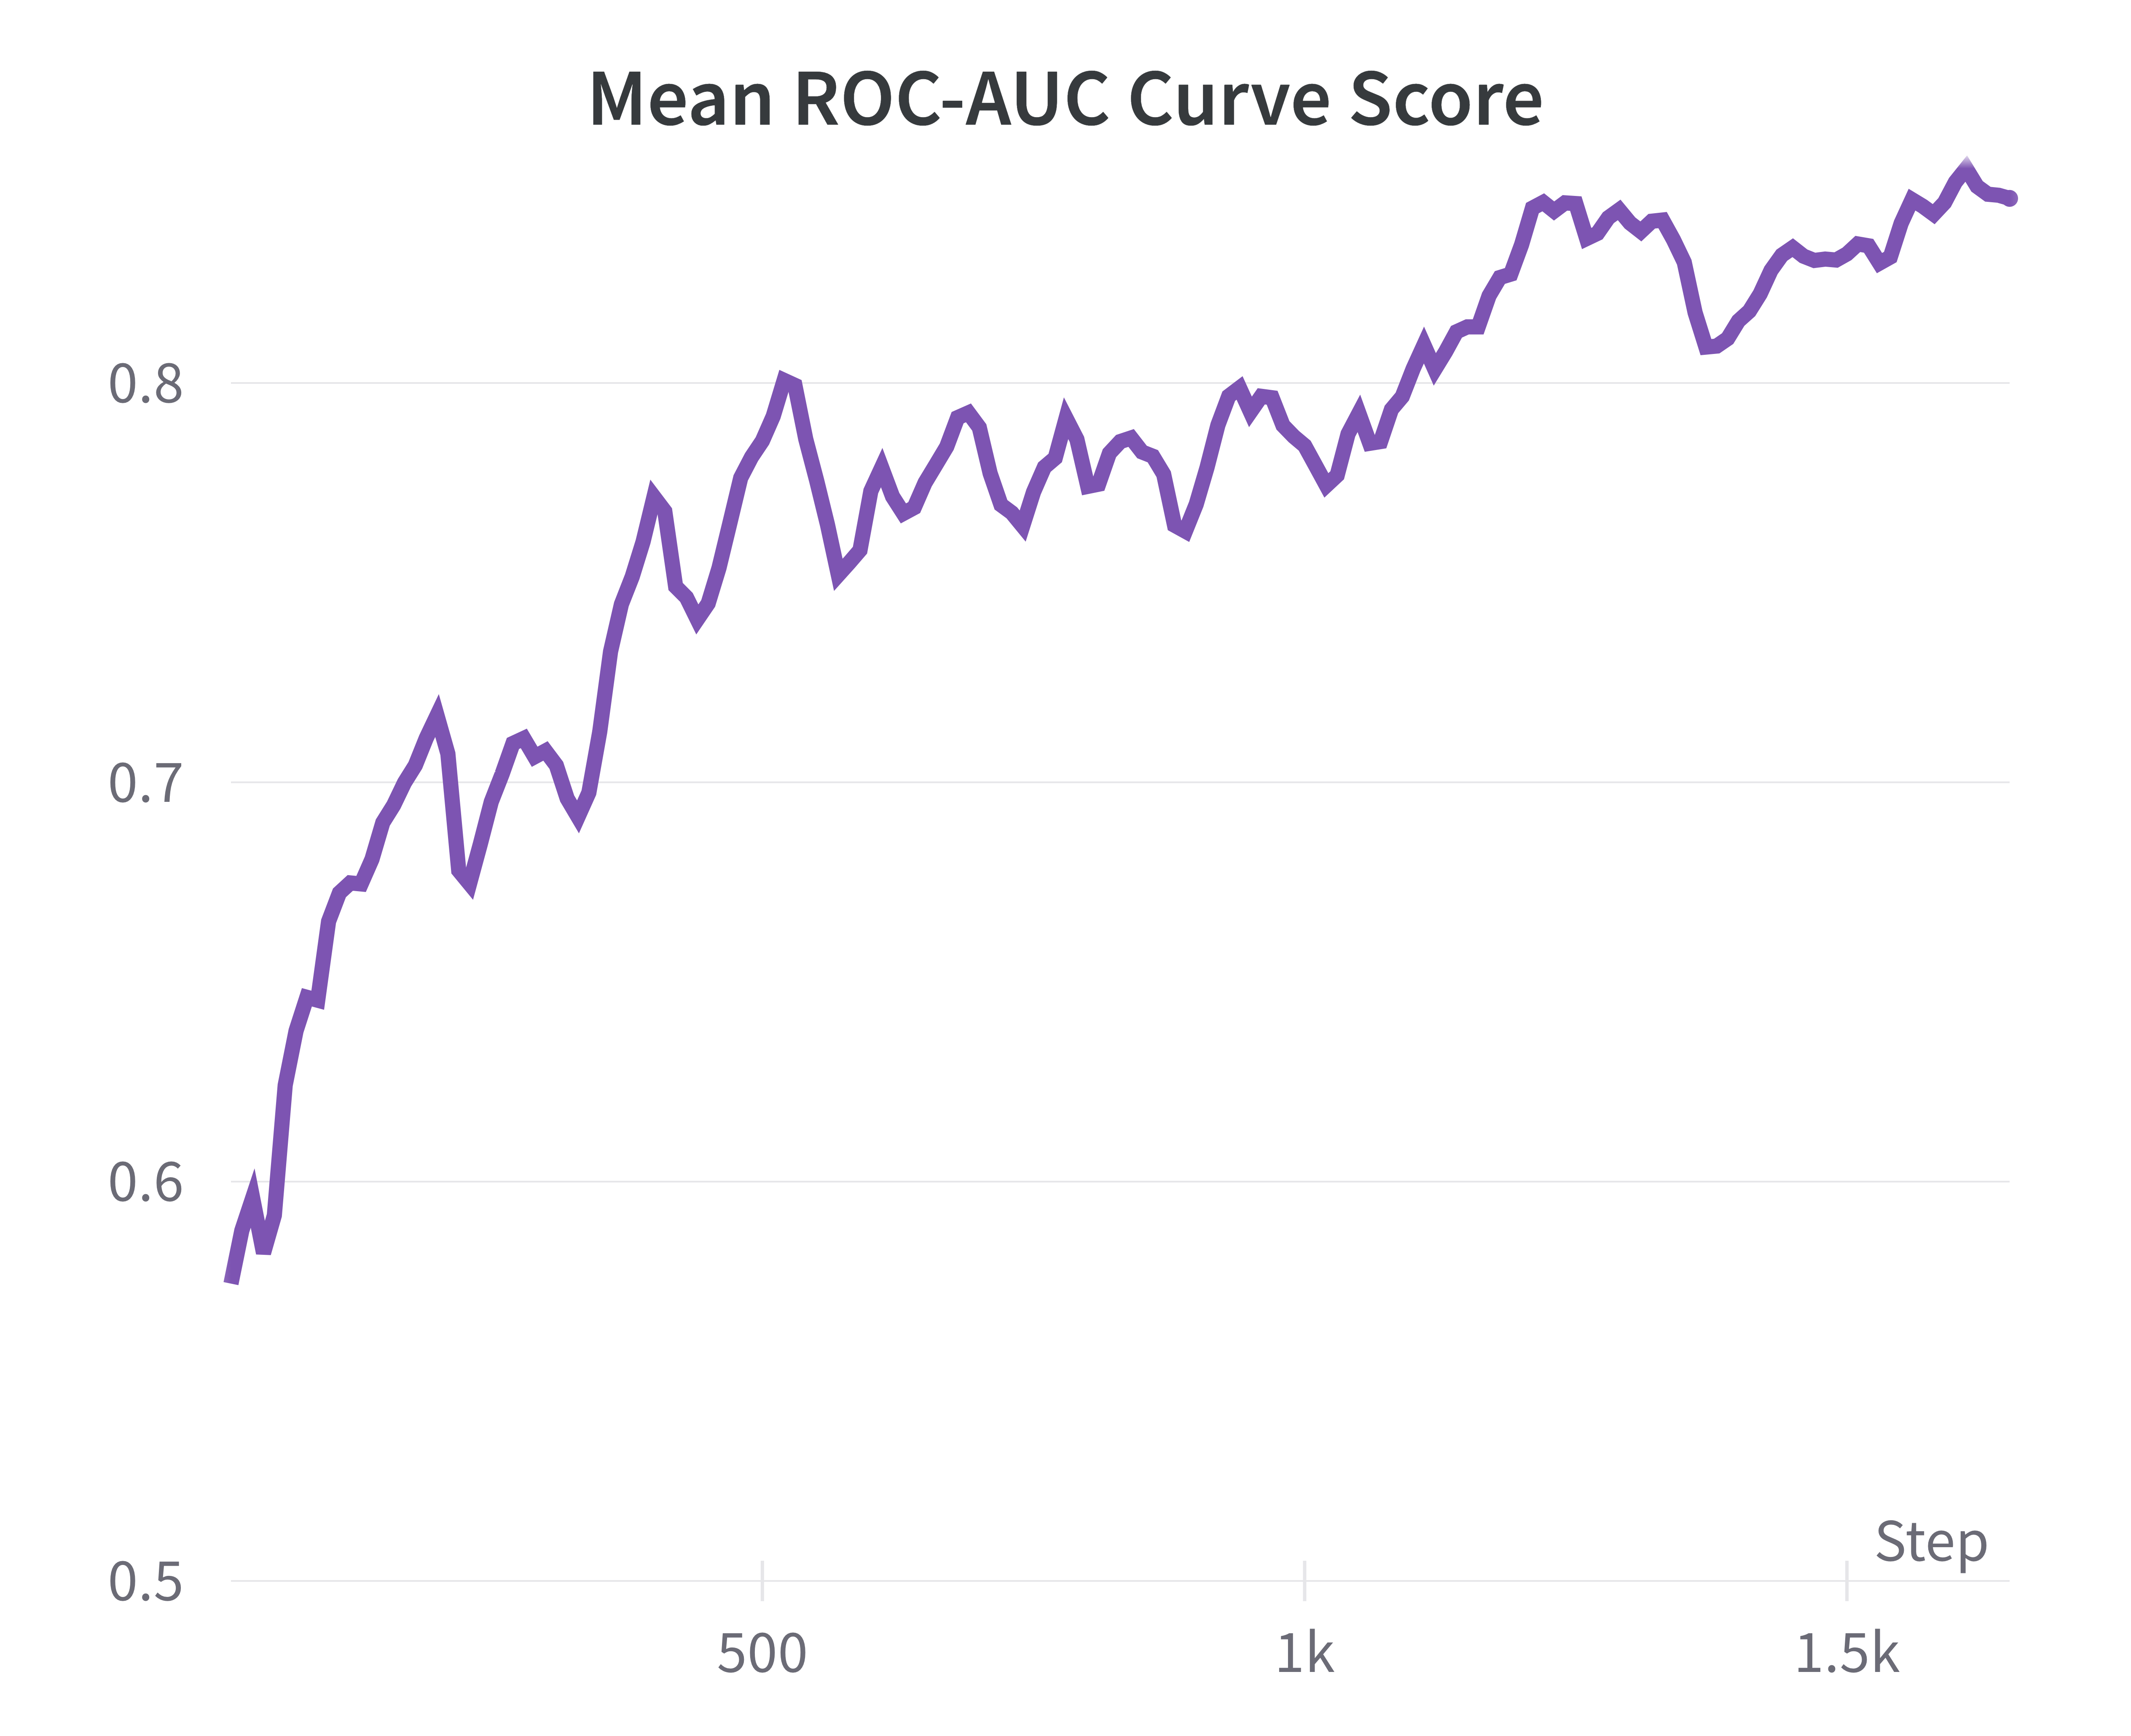

In [ ]:
wandb.init()
wandblogger = WandbLogger(project='PP_GCN_B', entity='ahenperm')
featurizer = dc.feat.ConvMolFeaturizer()
from deepchem.utils.save import load_from_disk
dataset_file= "/content/mdf2 - mdf2.csv"
dataset = load_from_disk(dataset_file)


loader = dc.data.CSVLoader(
      tasks=["class_1"], feature_field="SMILES",
      featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset,seed=3)
transformers = []

tasks=["class_1"]
model_dir =  "/content/gdrive/My Drive/{dc_gcn_perm_4}"

batch_size = 11

model = dc.models.GraphConvModel(
    len(tasks),
    dropout=0.1,
    batch_size=batch_size,
    batch_normalize=True,
    mode='classification',
    wandb_logger=wandblogger
    )

metric = dc.metrics.Metric(dc.metrics.roc_auc_score , np.mean,mode='classification')
vc_valid = ValidationCallback(valid_dataset, interval=10, metrics=[metric])
model.fit(train_dataset, nb_epoch=30,callbacks=vc_valid)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_14:0", shape=(76,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_13:0", shape=(76, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_17:0", shape=(190,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Res

Step 10 validation: mean-roc_auc_score=0.552469
Step 20 validation: mean-roc_auc_score=0.563272
Step 30 validation: mean-roc_auc_score=0.533951
Step 40 validation: mean-roc_auc_score=0.484568
Step 50 validation: mean-roc_auc_score=0.527006
Step 60 validation: mean-roc_auc_score=0.579475
Step 70 validation: mean-roc_auc_score=0.598765
Step 80 validation: mean-roc_auc_score=0.641204
Step 90 validation: mean-roc_auc_score=0.645833
Step 100 validation: mean-roc_auc_score=0.73534
Step 110 validation: mean-roc_auc_score=0.70679
Step 120 validation: mean-roc_auc_score=0.720679
Step 130 validation: mean-roc_auc_score=0.674383
Step 140 validation: mean-roc_auc_score=0.684414
Step 150 validation: mean-roc_auc_score=0.736111
Step 160 validation: mean-roc_auc_score=0.732253
Step 170 validation: mean-roc_auc_score=0.755401
Step 180 validation: mean-roc_auc_score=0.759259
Step 190 validation: mean-roc_auc_score=0.760031
Step 200 validation: mean-roc_auc_score=0.757716
Step 210 validation: mean-roc_a

0.39479473114013675

In [ ]:
print('training set score:', model.evaluate(train_dataset, [metric],transformers))
print('test set score:', model.evaluate(test_dataset, [metric], transformers))
print('valid set score:', model.evaluate(valid_dataset, [metric], transformers))


training set score: {'mean-roc_auc_score': 0.9409603973168215}
test set score: {'mean-roc_auc_score': 0.8241758241758241}
valid set score: {'mean-roc_auc_score': 0.8217592592592593}


In [ ]:
wandb.finish()

# Binary GCN result - prediciting class 1 

**training set score:** {'mean-roc_auc_score': 0.9409603973168215}

**test set score:** {'mean-roc_auc_score': 0.8241758241758241}

**valid set score:** {'mean-roc_auc_score': 0.8217592592592593}


  **Run summary:**
- eval/mean-roc_auc_score_(0)	0.82176
- train/loss	0.23791

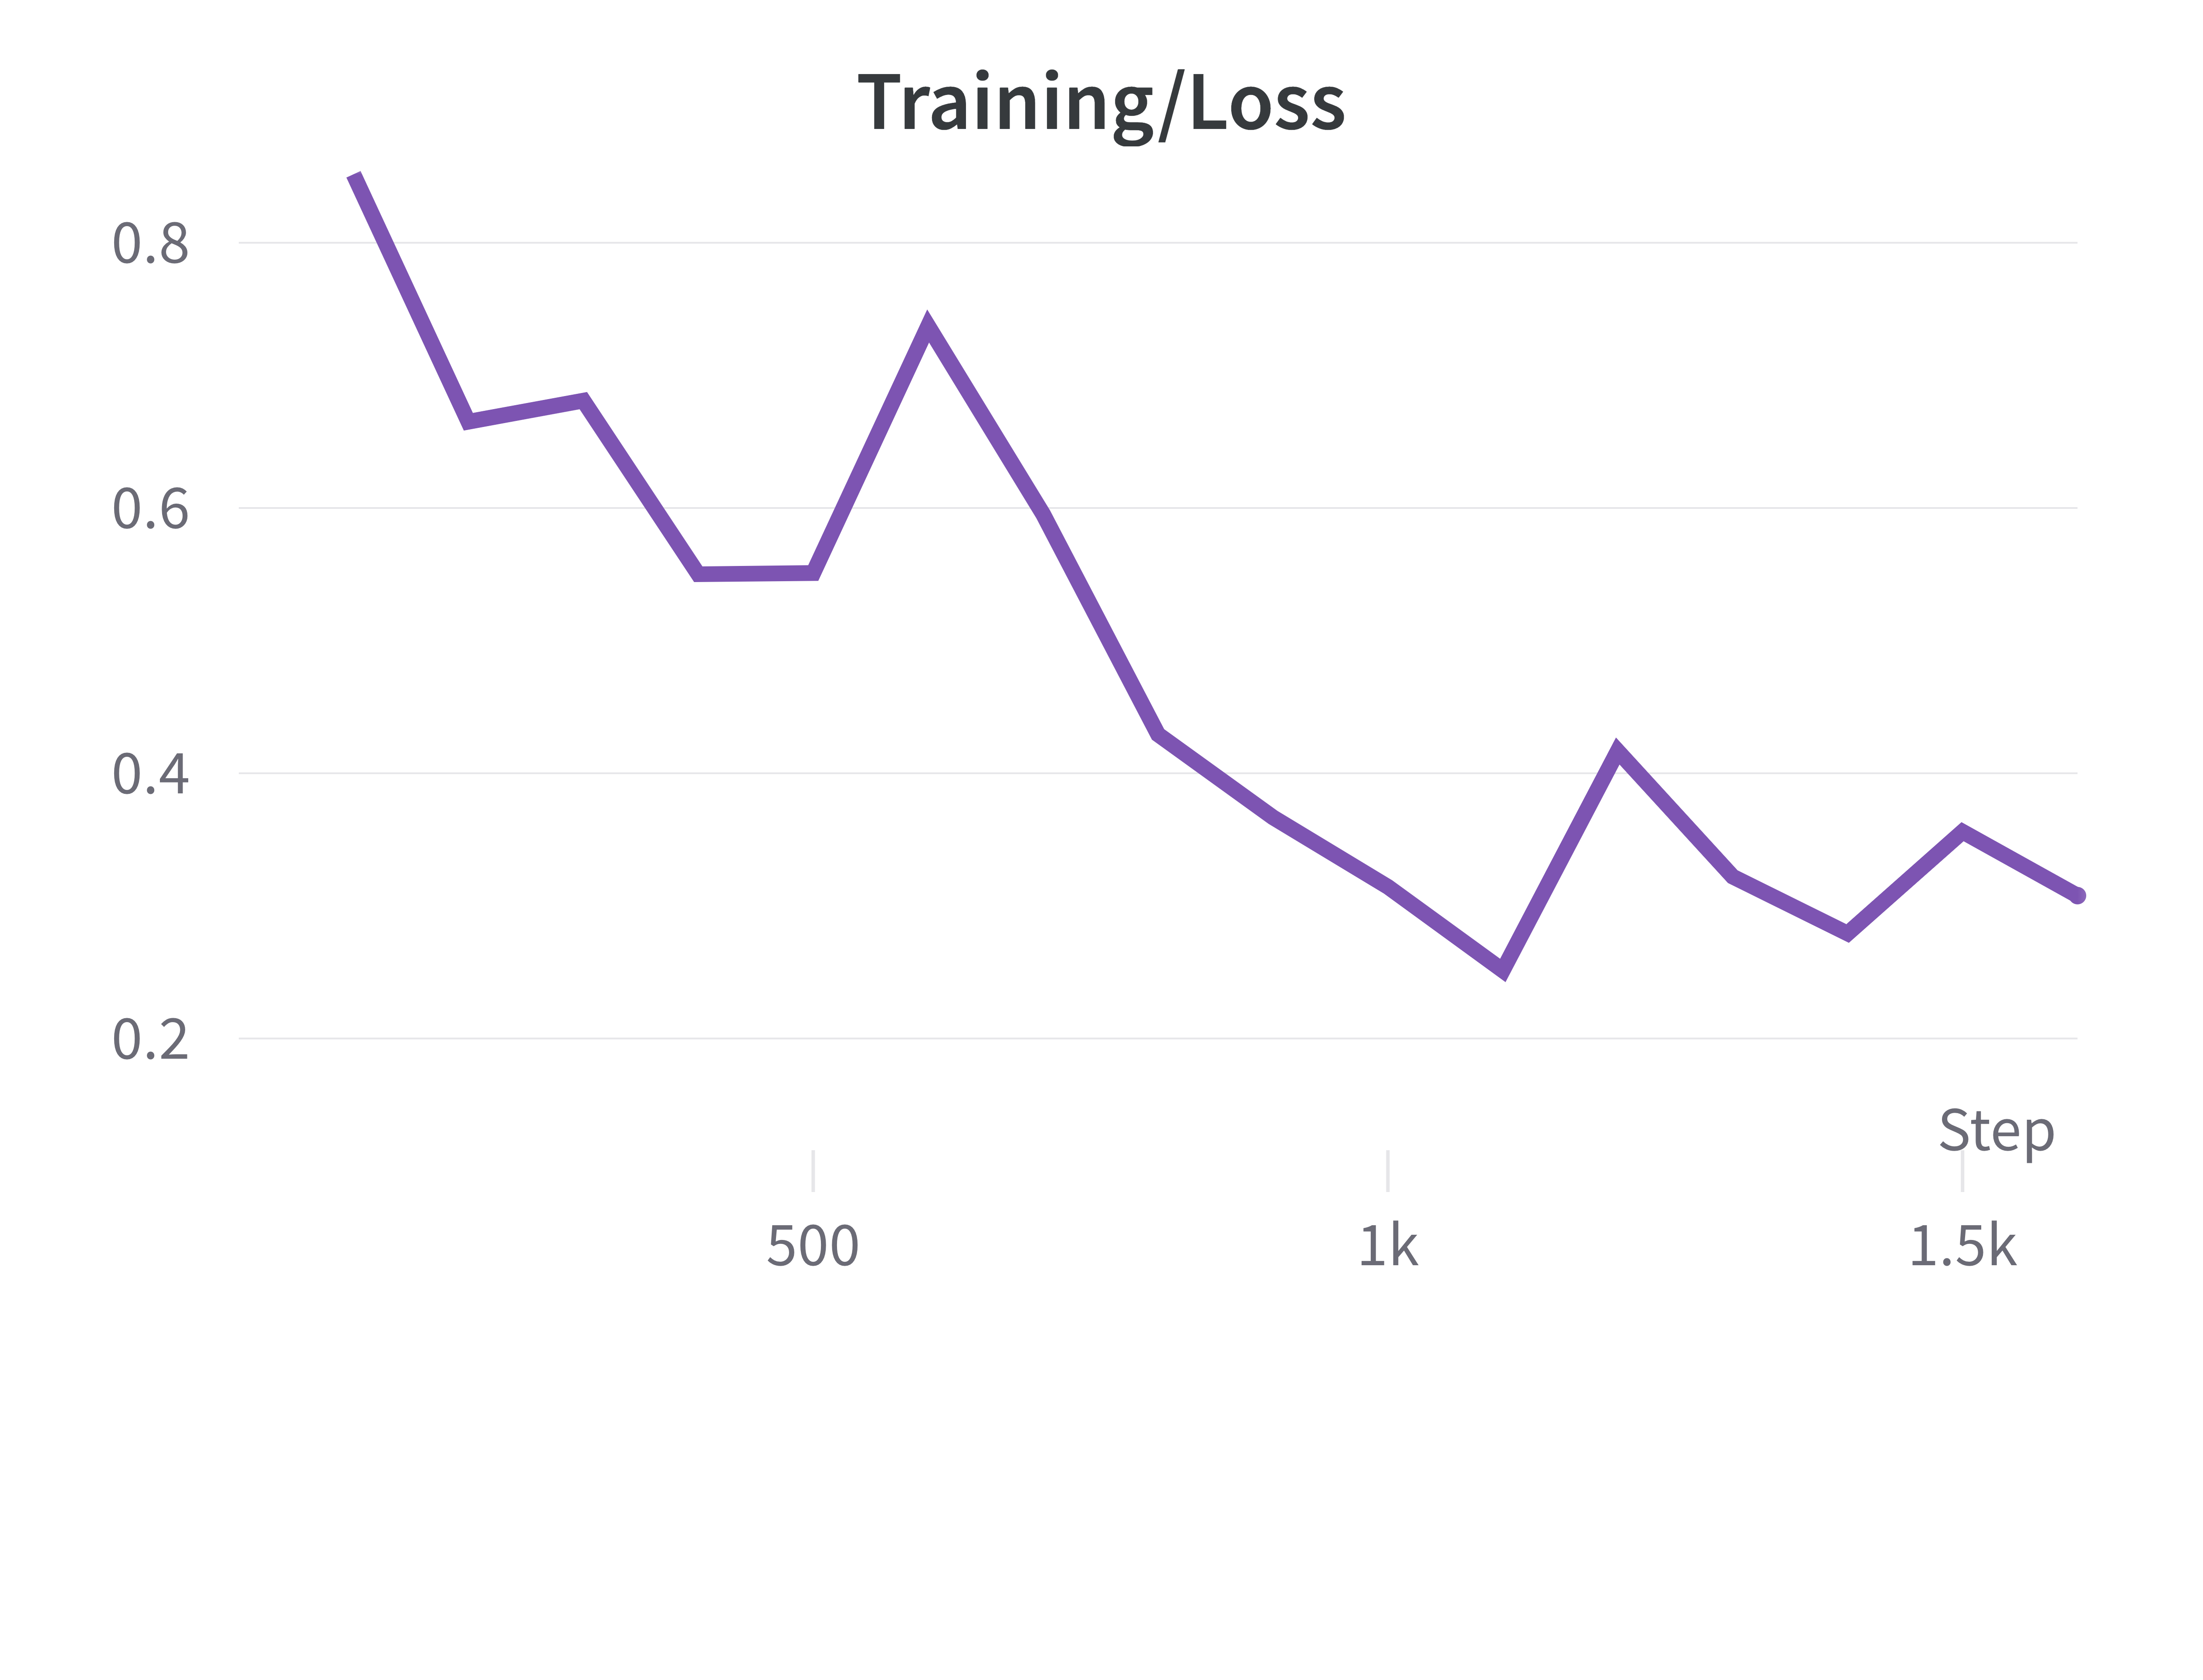

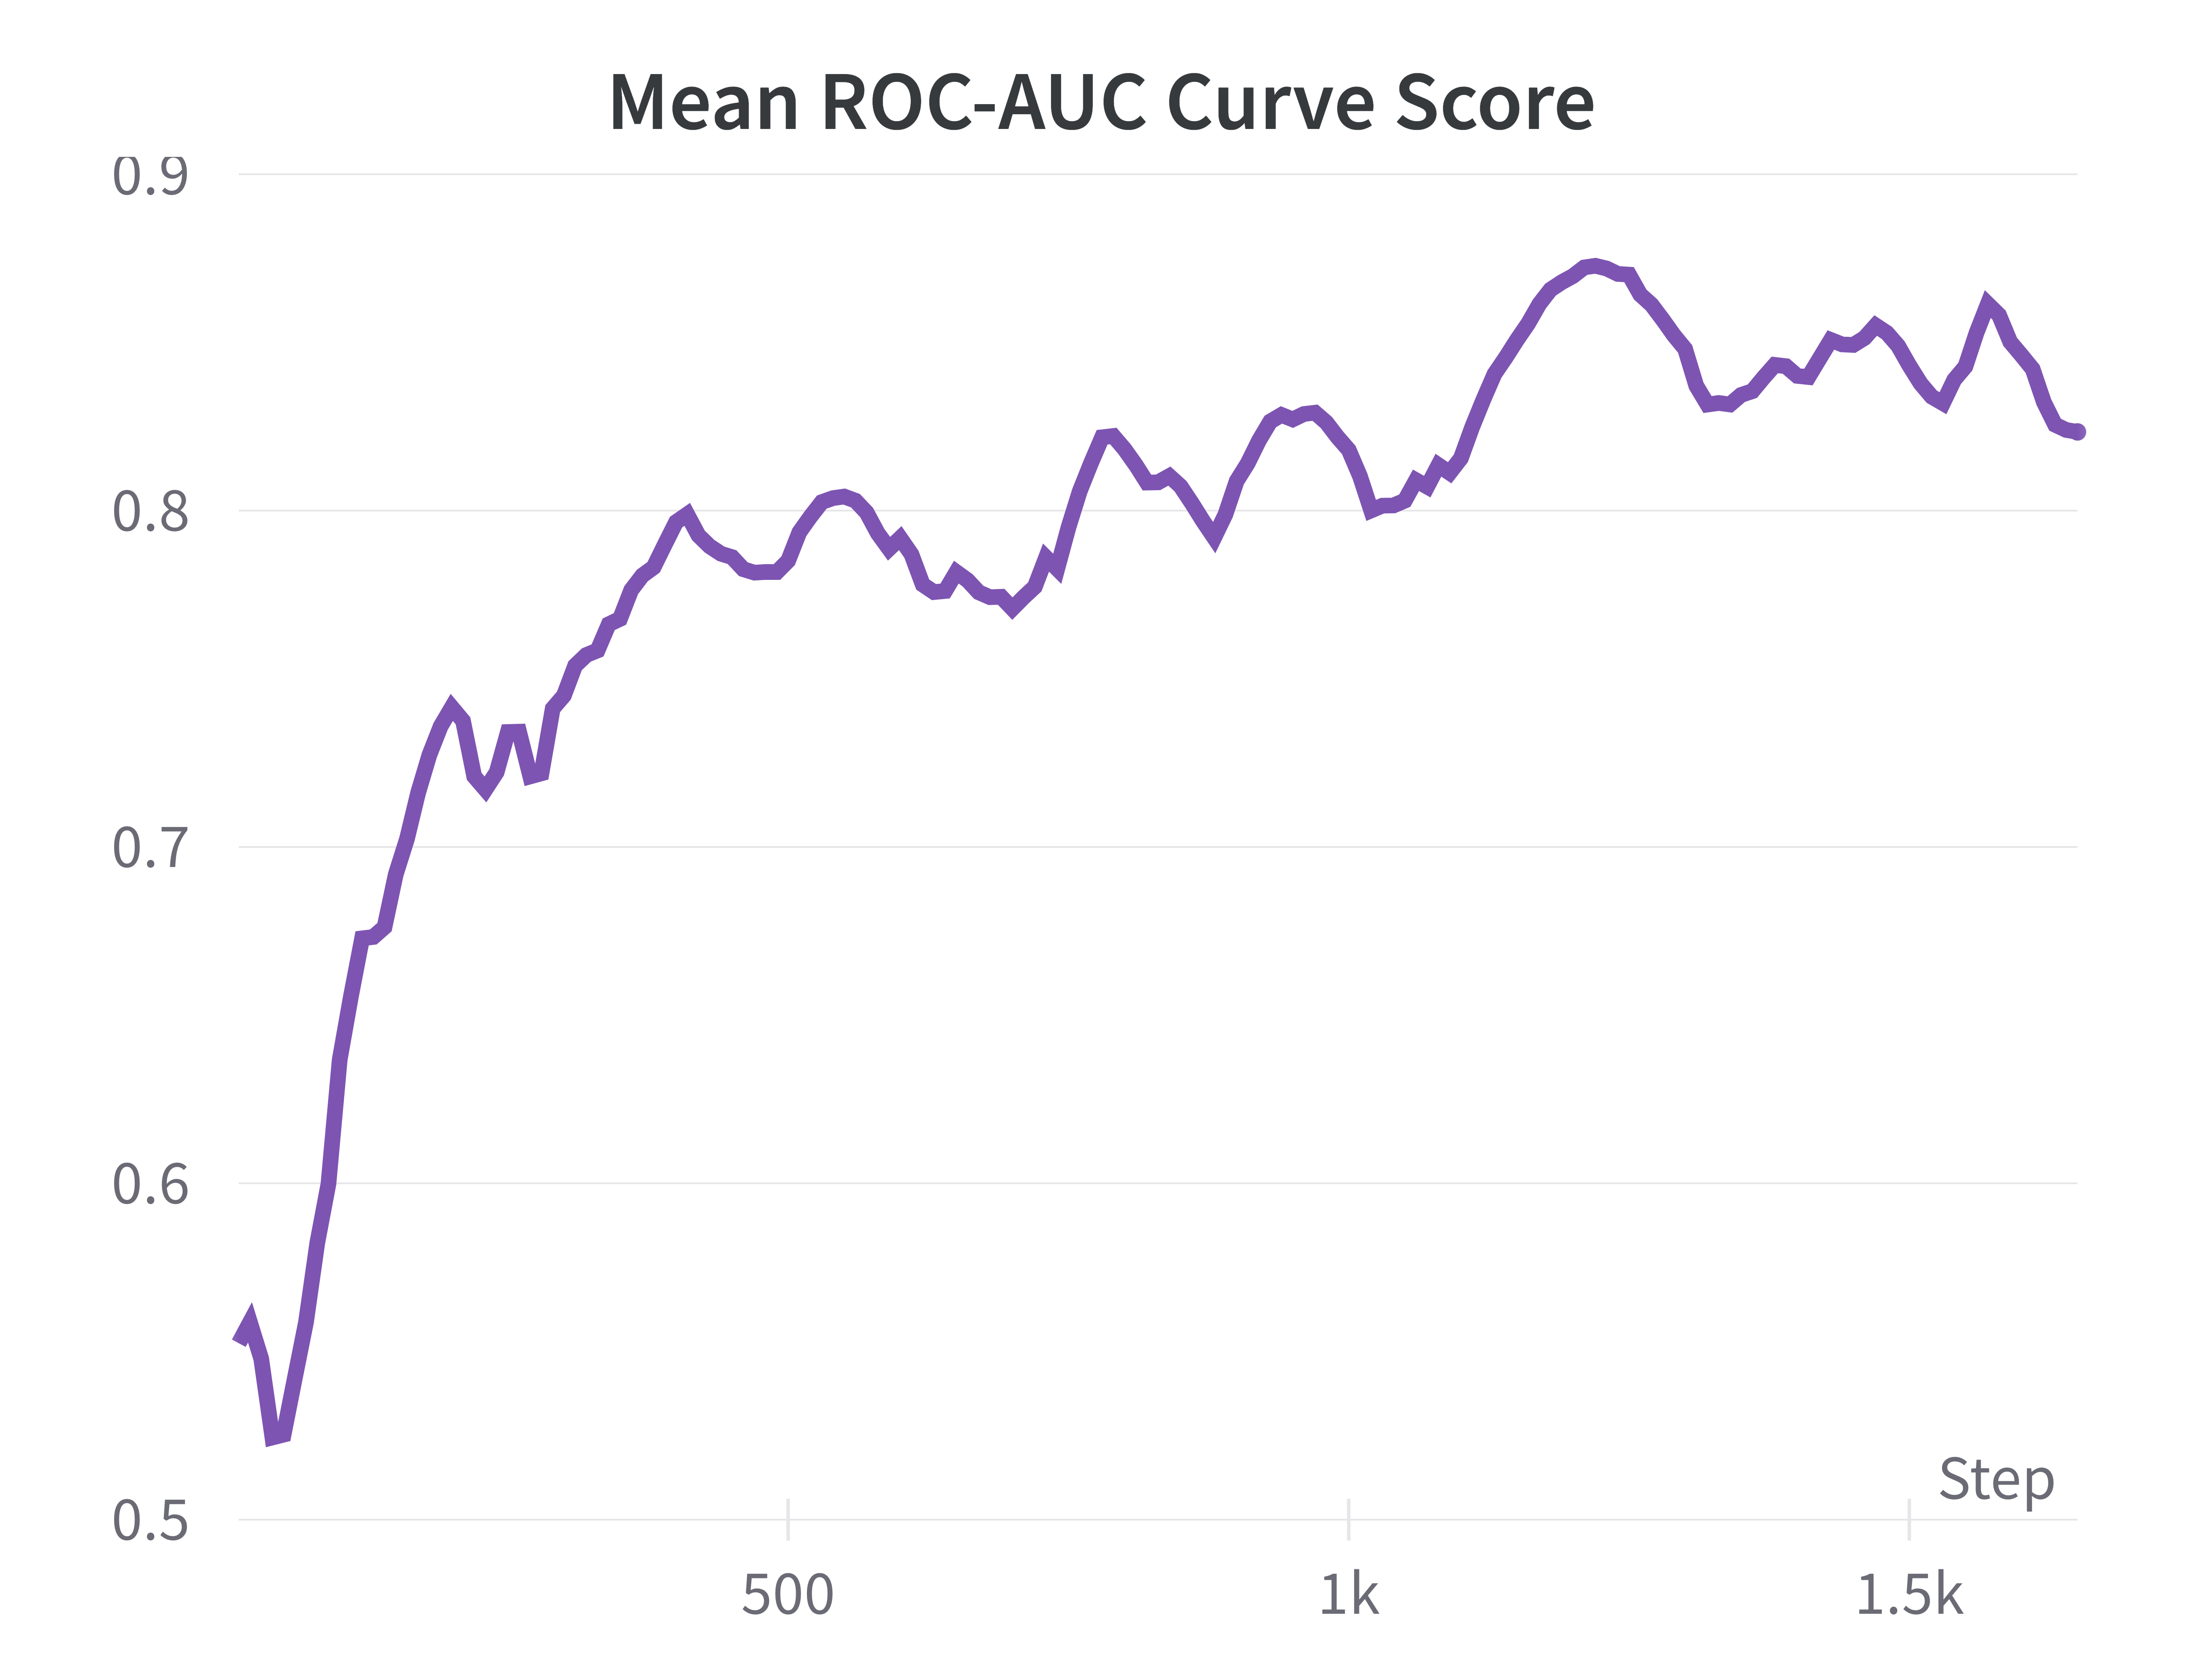

# binary GCN confusion matrix
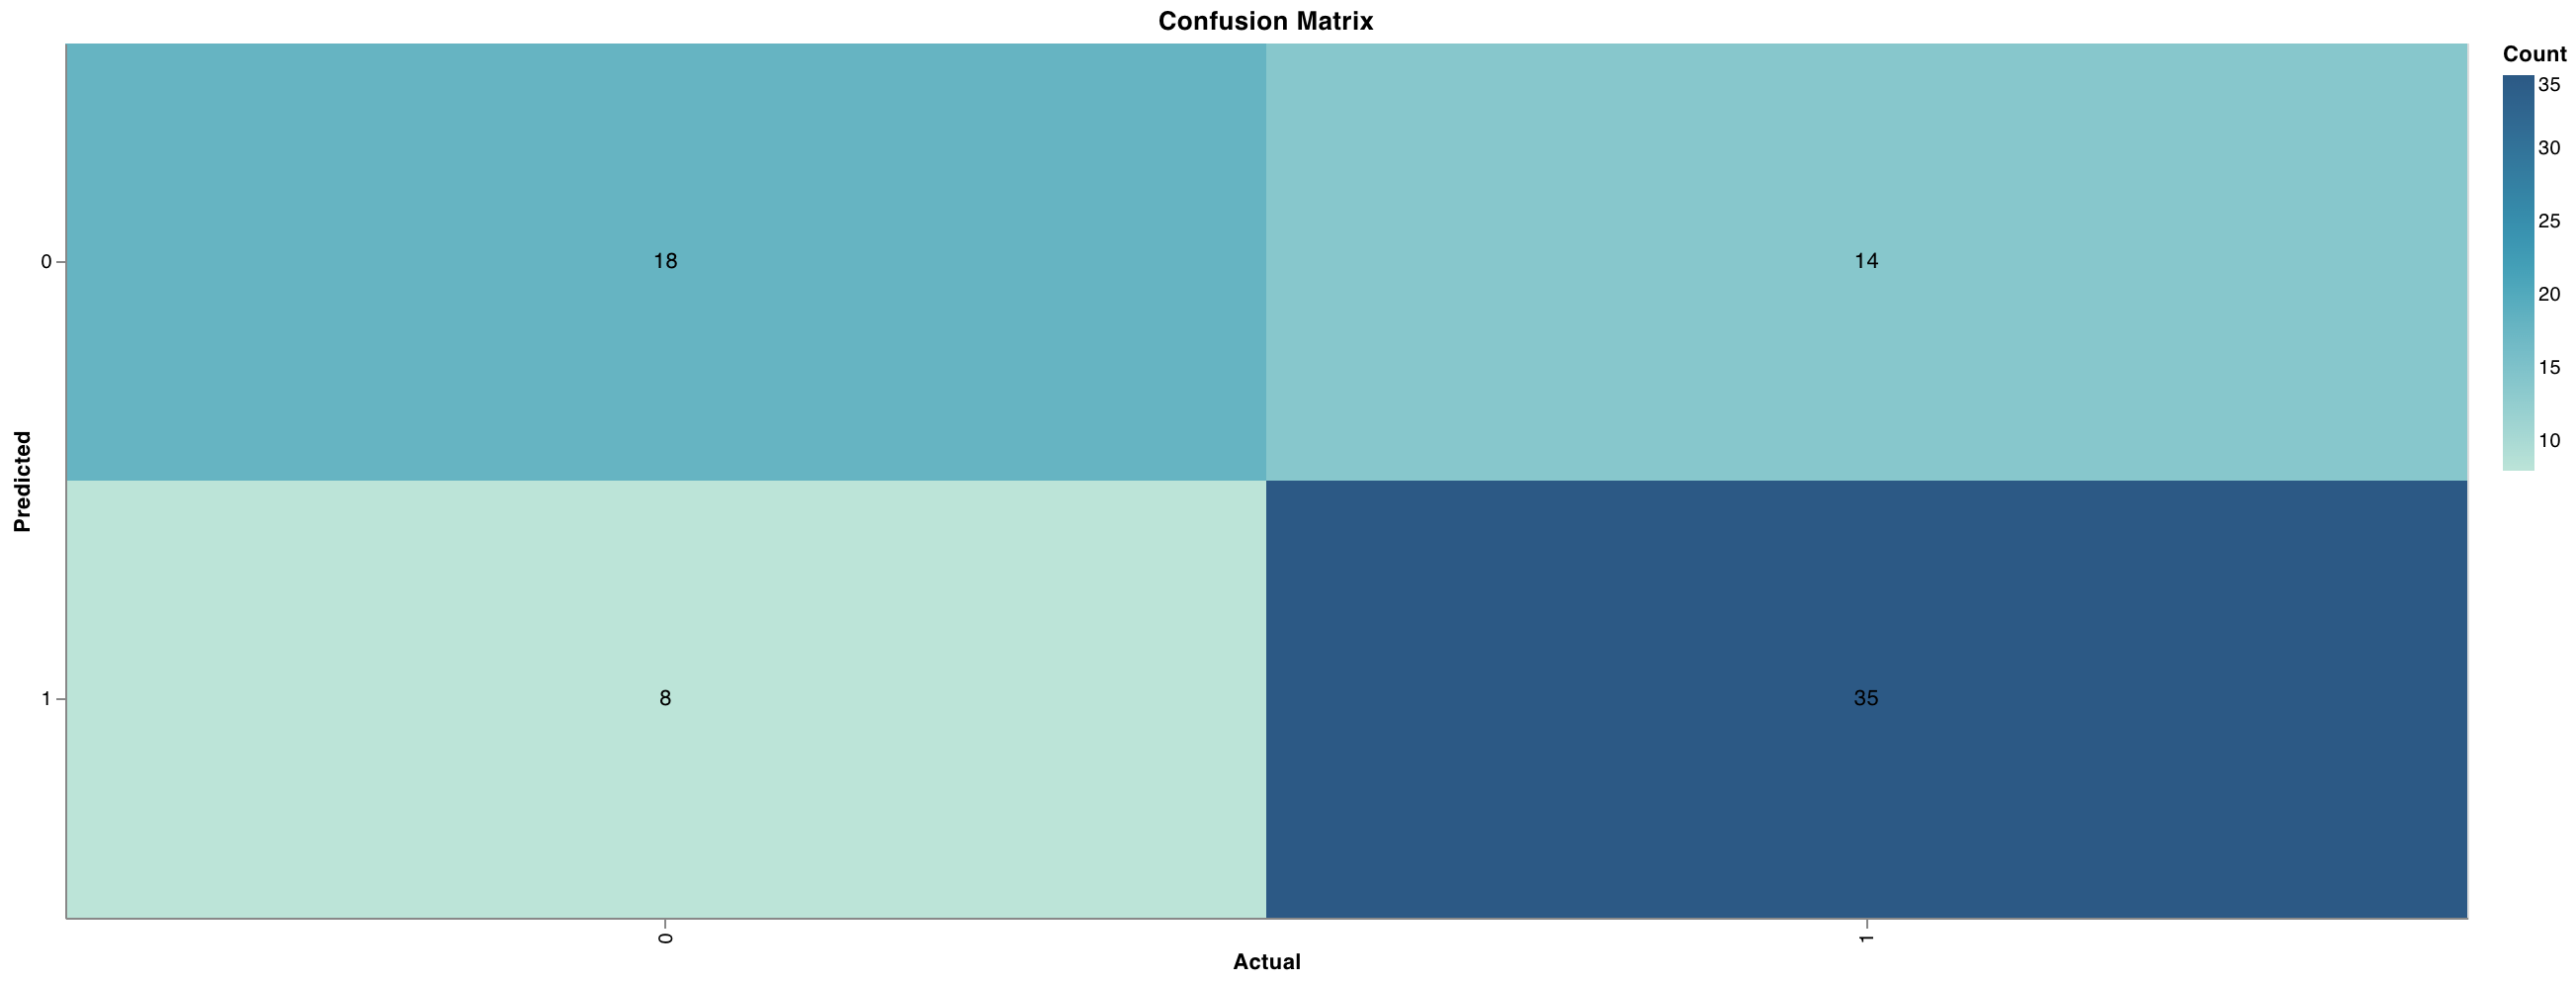


In [ ]:
wandb.init()
pred =  model.predict(test_dataset)
preds= np.argmax(pred,axis=-1)
y_true = test_dataset.y
wandb.sklearn.plot_confusion_matrix(y_true,preds)
wandb.finish()

So now we have a random forest model and a graph convolutional model predicting class 1 (compounds with a permeability barrier)

both models are split in the same way (seed=3)

now to test on test compounds


In [ ]:
test_df = pd.read_csv("test_compounds.csv")

In [ ]:
test_df

Compound                                             Smiles  Label  \
0   SPK-0256231  COc1ccc2ncc(=O)n(C[C@H](N)[C@@H]3CC[C@H](CO3)N...      0   
1   SPK-0256230  COc1ccc2ccc(=O)n(C[C@H](N)[C@@H]3CC[C@H](CO3)N...      0   
2   SPK-0256222  COc1ccc2ccc(F)c(C[C@H](N)[C@@H]3CC[C@H](CO3)NC...      0   
3   SPK-0255039  CC1=C(C(=O)NC2C3SC(C)(C)C(N3C2=O)C(O)=O)C(=NO1...      1   
4   SPK-0255038  CCCC1CC(N(C)C1)C(=O)NC(C(C)Cl)C1OC(SC)C(O)C(O)C1O      1   
5   SPK-0255036  COC1C=COC2(C)OC3=C(C2=O)C2=C(O)C(C=NN4CCN(C)CC...      1   
6   SPK-0255035  OC(=O)C=CC(O)=O.CCN(CC)CCSCC(=O)OC1CC(C)(C=C)C...      1   
7   SPK-0127417  OC(=O)CC(=O)Nc1nc2CC[C@@H](Cc2s1)NC(=O)c1cc(Br...      0   
8   SPK-0127416  COC(=O)CC(=O)Nc1nc2CC[C@H](Cc2s1)NC(=O)c1cc(Br...      0   
9        Comp_2  CN1N=CC2=C1[C@@H](C(N(C)C)=O)N3C[C@@H]2N(OS(=O...      1   
10      ETX0462  CN1N=CC2=C1[C@@H](/C(NC)=N/O)N3C[C@@H]2N(OS(=O...      0   

    class_0  class_1  
0         1        0  
1         1        0  
2         1        0  
3         0        1  
4         0        1  
5         0        1  
6         0        1  
7         1        0  
8         1        0  
9         0        1  
10        1        0

In [81]:


featurizer = dc.feat.ConvMolFeaturizer()
from deepchem.utils.save import load_from_disk
dataset_file= "/content/mdf2 - mdf2.csv"
dataset = load_from_disk(dataset_file)


loader = dc.data.CSVLoader(
      tasks=["class_1"], feature_field="SMILES",
      featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset,seed=3)
transformers = []

tasks=["class_1"]
model_dir =  "/content/gdrive/My Drive/{dc_gcn_1}"

batch_size = 11

model = dc.models.GraphConvModel(
    len(tasks),
    dropout=0.1,
    batch_size=batch_size,
    batch_normalize=True,
    mode='classification',
    model_dir=model_dir
    )

metric = dc.metrics.Metric(dc.metrics.roc_auc_score , np.mean,mode='classification')
vc_valid = ValidationCallback(valid_dataset, interval=10, metrics=[metric])
model.fit(train_dataset, nb_epoch=30,callbacks=vc_valid)

pred_comp = pd.read_csv("test_compounds.csv")
featurizer = dc.feat.ConvMolFeaturizer()
from deepchem.utils.save import load_from_disk
prediction_file= "test_compounds.csv"
predictionset = load_from_disk(prediction_file)

loader = dc.data.CSVLoader(
      tasks=["class_1"], feature_field="Smiles",
      featurizer=featurizer)
predictionset = loader.create_dataset(prediction_file)


pred_gcn =  model.predict(predictionset)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_11/graph_pool_23/Reshape_14:0", shape=(76,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_11/graph_pool_23/Reshape_13:0", shape=(76, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_11/graph_pool_23/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_11/graph_pool_23/Reshape_17:0", shape=(190,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_11/graph_p

Step 10 validation: mean-roc_auc_score=0.62963
Step 20 validation: mean-roc_auc_score=0.625772
Step 30 validation: mean-roc_auc_score=0.652006
Step 40 validation: mean-roc_auc_score=0.650463
Step 50 validation: mean-roc_auc_score=0.64429
Step 60 validation: mean-roc_auc_score=0.699846
Step 70 validation: mean-roc_auc_score=0.689815
Step 80 validation: mean-roc_auc_score=0.656636
Step 90 validation: mean-roc_auc_score=0.646605
Step 100 validation: mean-roc_auc_score=0.733796
Step 110 validation: mean-roc_auc_score=0.731481
Step 120 validation: mean-roc_auc_score=0.70216
Step 130 validation: mean-roc_auc_score=0.682099
Step 140 validation: mean-roc_auc_score=0.647377
Step 150 validation: mean-roc_auc_score=0.66821
Step 160 validation: mean-roc_auc_score=0.667438
Step 170 validation: mean-roc_auc_score=0.645833
Step 180 validation: mean-roc_auc_score=0.652006
Step 190 validation: mean-roc_auc_score=0.684414
Step 200 validation: mean-roc_auc_score=0.701389
Step 210 validation: mean-roc_auc

In [82]:
pred_gcn = np.argmax(pred_gcn,axis=-1)
pred_gcn =pd.DataFrame(data=pred_gcn)

In [83]:
pred_gcn

0
0   0
1   0
2   0
3   1
4   0
5   1
6   1
7   0
8   1
9   0
10  0

# Binary GCN predicitons on test compounds

- predicted 7/9 spark compounds
- the compounds it failed were: (#5) SPK-0255038 and (#9) SPK-0127416
- SPK-0255038 is classified as having permeability issues, but our model classifed it as not having permeability issues
- SPK-0127416 was classified as not having permeability issues but our model classified it as having permeability issues
- predicted both tomassi compounds as not having a permeability barrier (index 9 and 10)
- the model is saved at '/content/gdrive/My Drive/{dc_gcn_1}'



To reload model:


```
# model = GraphConvModel(model_dir="/content/gdrive/My Drive/{dc_gcn_1}")
model.restore()
```

Now for predictions of RF model


In [ ]:

pred_comp = pd.read_csv("test_compounds.csv")
featurizer = dc.feat.CircularFingerprint(size=1024,radius=3)
n_features = 1024
tasks=["class_1"]
from deepchem.utils.save import load_from_disk
prediction_file= "test_compounds.csv"
predictionset = load_from_disk(prediction_file)

loader = dc.data.CSVLoader(
      tasks=["class_1"], feature_field="Smiles",
      featurizer=featurizer)
predictionset = loader.create_dataset(prediction_file)


In [ ]:
dc.trans.NormalizationTransformer(transform_y=True)
predictionset = transformer.transform(predictionset)

In [ ]:
pred_rf =  modelrf.predict(predictionset)

In [ ]:
pred_rf

array([[0.84      , 0.16      ],
       [0.78      , 0.22      ],
       [0.4575    , 0.5425    ],
       [0.07      , 0.93      ],
       [0.3       , 0.7       ],
       [0.33166667, 0.66833333],
       [0.17      , 0.83      ],
       [0.43      , 0.57      ],
       [0.33      , 0.67      ],
       [0.55      , 0.45      ],
       [0.5       , 0.5       ]])

In [ ]:
pred_rf = np.argmax(pred_rf,axis=-1)

In [ ]:
pred_rf

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0])

In [84]:
#mdf.to_csv('mdf1.csv')
#ecfp = circular fingerprint


featurizer = dc.feat.CircularFingerprint(size=1024,radius=3)
n_features = 1024
tasks=["class_1"]


from deepchem.utils.save import load_from_disk
dataset_file= "/content/mdf2 - mdf2.csv"
dataset = load_from_disk(dataset_file)

loader = dc.data.CSVLoader(
      tasks=["class_1"], feature_field="SMILES",
      featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

splitter = dc.splits.RandomStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset,seed=3)
transformers = [
    dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)
  
from sklearn.ensemble import RandomForestClassifier
sklearn_model = RandomForestClassifier(n_estimators=100,max_features='auto' )
modelrf = dc.models.SklearnModel(sklearn_model,model_dir="/content/gdrive/My Drive/{RF_perm}")

metric = dc.metrics.Metric(dc.metrics.roc_auc_score , np.mean,mode='classification')

modelrf.fit(train_dataset)
print('training set score:', modelrf.evaluate(train_dataset, [metric]))
print('test set score:', modelrf.evaluate(test_dataset, [metric]))
print('valid set score:', modelrf.evaluate(valid_dataset, [metric]))





training set score: {'mean-roc_auc_score': 0.9996225932322651}
test set score: {'mean-roc_auc_score': 0.8608}
valid set score: {'mean-roc_auc_score': 0.8058000000000001}


In [85]:
pred_comp = pd.read_csv("test_compounds.csv")
featurizer = dc.feat.CircularFingerprint(size=1024,radius=3)
n_features = 1024
tasks=["class_1"]
from deepchem.utils.save import load_from_disk
prediction_file= "test_compounds.csv"
predictionset = load_from_disk(prediction_file)

loader = dc.data.CSVLoader(
      tasks=["class_1"], feature_field="Smiles",
      featurizer=featurizer)

predictionset = loader.create_dataset(prediction_file)
dc.trans.NormalizationTransformer(transform_y=True)
predictionset = transformer.transform(predictionset)
pred_rf =  modelrf.predict(predictionset)
pred_rf
pred_rf = np.argmax(pred_rf,axis=-1)
pred_rf

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0])

# Random Forest results on new compounds

- RF model predicted 6/9 correctly
- it missclassified (#3) SPK-0256222, (#8) SPK-0127417 and (#9) SPK-0127416
- all three were meant to be 0 but model classed as 1
- model is a bit biased towards permeability issues - not neccesarily a bad thing


In [86]:
DATASET_FILE ='/content/new_out.sdf'
mols = [m for m in Chem.SDMolSupplier(DATASET_FILE) if m is not None ]

In [88]:
loader = dc.data.SDFLoader(tasks=[],# dont need task (moreover, passing the task can lead to inconsitencies in data shapes)
                        featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=True),
                        sanitize=True) 
frag_dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)

/usr/local/lib/python3.7/dist-packages/deepchem/feat/base_classes.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(features)
/usr/local/lib/python3.7/dist-packages/deepchem/feat/graph_features.py:797: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (l, m) in zip(valid_frag_inds, features)
/usr/local/lib/python3.7/dist-packages/deepchem/data/data_loader.py:885: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) i

In [89]:
print(frag_dataset.X.shape)
tr = dc.trans.FlatteningTransformer(frag_dataset)
frag_dataset = tr.transform(frag_dataset)
print(frag_dataset.X.shape)

(12,)
(382,)


In [90]:
loader = dc.data.SDFLoader(tasks=["Label"], 
                           featurizer=dc.feat.ConvMolFeaturizer(),
                           sanitize=True)
dataset = loader.create_dataset(DATASET_FILE, shard_size=2000)

In [91]:
pred = np.squeeze(model.predict(dataset))[:, 1] # probabilitiy of class 1
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"])  # turn to dataframe for convinience

# fragments
pred_frags = np.squeeze(model.predict(frag_dataset))[:, 1]
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])

In [92]:
# merge 2 dataframes by molecule names
df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
df['Contrib'] = df["Molecule"] - df["Fragment"]

In [94]:
df

Fragment  Molecule  \
C=CC1(C)CC(OC(=O)CSCCN(CC)CC)C2(C)C(C)CCC3(CCC(...  0.681695  0.515068   
C=CC1(C)CC(OC(=O)CSCCN(CC)CC)C2(C)C(C)CCC3(CCC(...  0.539014  0.515068   
C=CC1(C)CC(OC(=O)CSCCN(CC)CC)C2(C)C(C)CCC3(CCC(...  0.622570  0.515068   
C=CC1(C)CC(OC(=O)CSCCN(CC)CC)C2(C)C(C)CCC3(CCC(...  0.451633  0.515068   
C=CC1(C)CC(OC(=O)CSCCN(CC)CC)C2(C)C(C)CCC3(CCC(...  0.451633  0.515068   
...                                                      ...       ...   
O=C(O)CC(=O)Nc1nc2c(s1)C[C@@H](NC(=O)c1cc(Br)c(...  0.040041  0.252913   
O=C(O)CC(=O)Nc1nc2c(s1)C[C@@H](NC(=O)c1cc(Br)c(...  0.106778  0.252913   
O=C(O)CC(=O)Nc1nc2c(s1)C[C@@H](NC(=O)c1cc(Br)c(...  0.067570  0.252913   
O=C(O)CC(=O)Nc1nc2c(s1)C[C@@H](NC(=O)c1cc(Br)c(...  0.144553  0.252913   
O=C(O)CC(=O)Nc1nc2c(s1)C[C@@H](NC(=O)c1cc(Br)c(...  0.238685  0.252913   

                                                     Contrib  
C=CC1(C)CC(OC(=O)CSCCN(CC)CC)C2(C)C(C)CCC3(CCC(... -0.166627  
C=CC1(C)CC(OC(=O)CSCCN(CC)CC)C2(C)C(C)CCC3(CCC(... -0.023946  
C=CC1(C)CC(OC(=O)CSCCN(CC)CC)C2(C)C(C)CCC3(CCC(... -0.107502  
C=CC1(C)CC(OC(=O)CSCCN(CC)CC)C2(C)C(C)CCC3(CCC(...  0.063435  
C=CC1(C)CC(OC(=O)CSCCN(CC)CC)C2(C)C(C)CCC3(CCC(...  0.063435  
...                                                      ...  
O=C(O)CC(=O)Nc1nc2c(s1)C[C@@H](NC(=O)c1cc(Br)c(...  0.212872  
O=C(O)CC(=O)Nc1nc2c(s1)C[C@@H](NC(=O)c1cc(Br)c(...  0.146135  
O=C(O)CC(=O)Nc1nc2c(s1)C[C@@H](NC(=O)c1cc(Br)c(...  0.185343  
O=C(O)CC(=O)Nc1nc2c(s1)C[C@@H](NC(=O)c1cc(Br)c(...  0.108360  
O=C(O)CC(=O)Nc1nc2c(s1)C[C@@H](NC(=O)c1cc(Br)c(...  0.014228  

[382 rows x 3 columns]

In [95]:
def vis_contribs(mols, df, smi_or_sdf = "sdf"): 
    # input format of file, which was used to create dataset determines the order of atoms, 
    # so we take it into account for correct mapping!
    maps = []
    for mol  in mols:
        wt = {}
        if smi_or_sdf == "smi":
            for n,atom in enumerate(Chem.rdmolfiles.CanonicalRankAtoms(mol)):
                wt[atom] = df.loc[mol.GetProp("_Name"),"Contrib"][n]
        if smi_or_sdf == "sdf":        
            for n,atom in enumerate(range(mol.GetNumHeavyAtoms())):
                wt[atom] = df.loc[Chem.MolToSmiles(mol),"Contrib"][n]
        maps.append(SimilarityMaps.GetSimilarityMapFromWeights(mol,wt, colorMap="coolwarm",contourLines=5,alpha=0.1))
    return maps

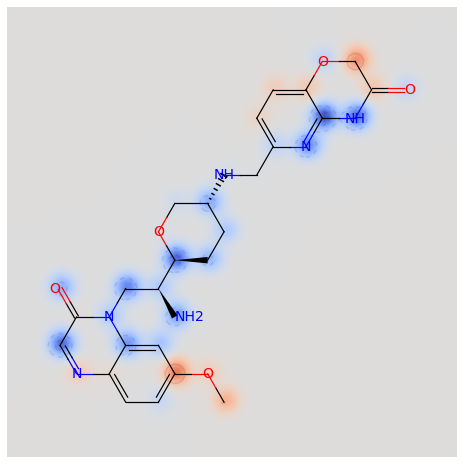

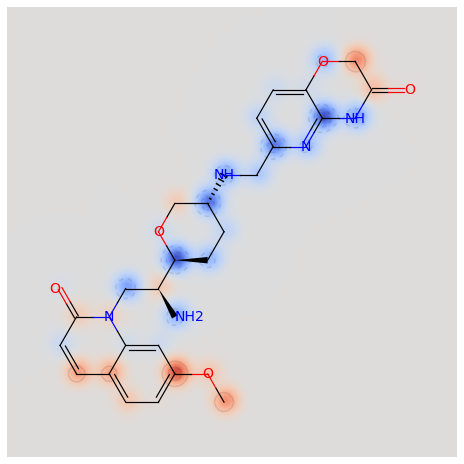

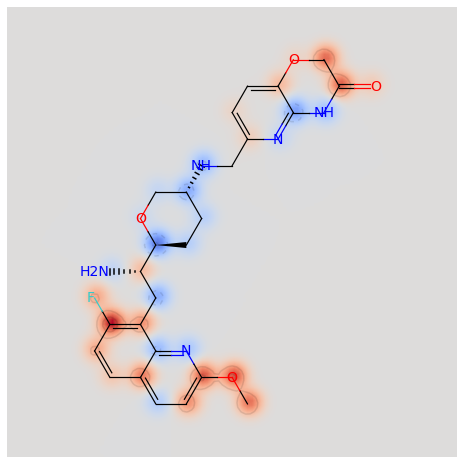

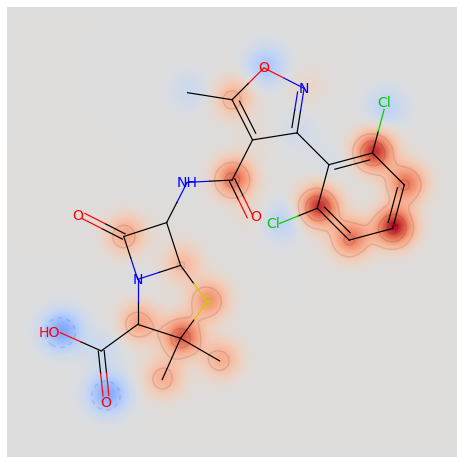

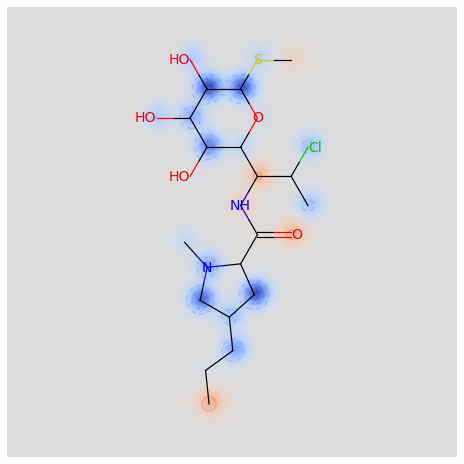

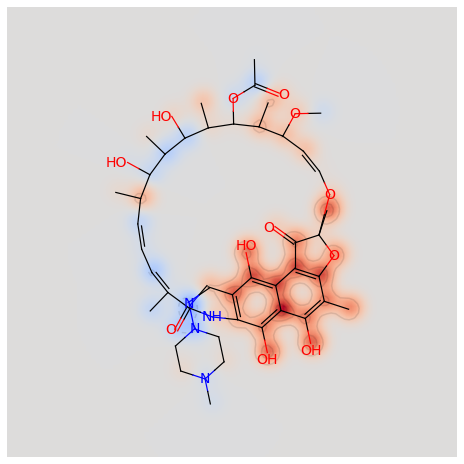

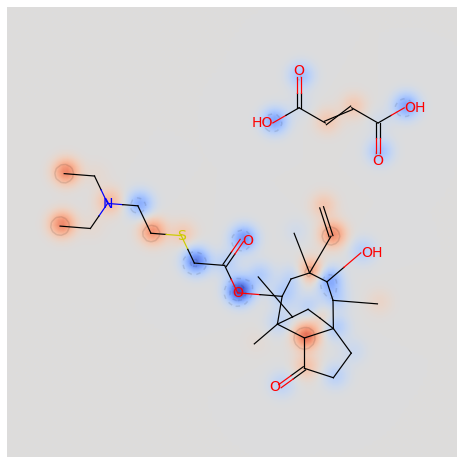

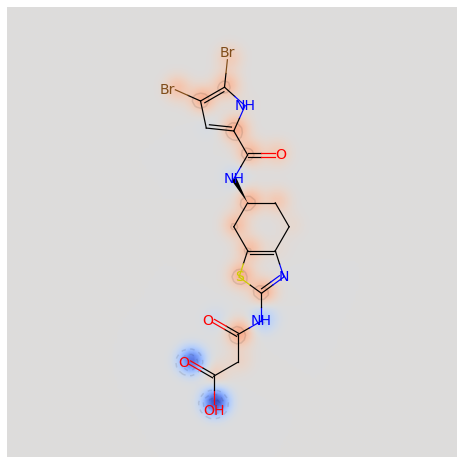

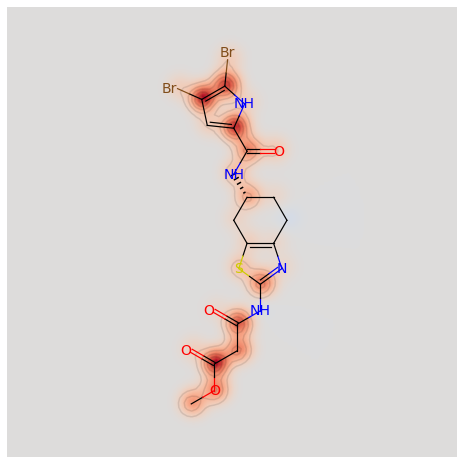

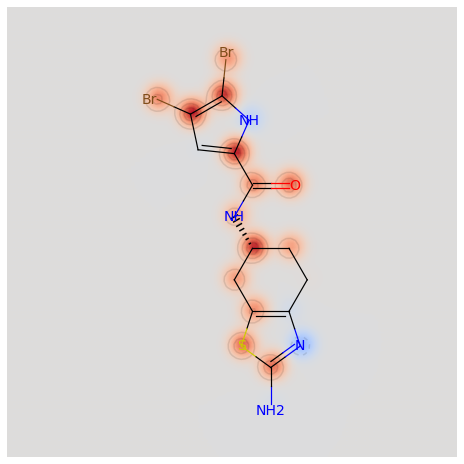

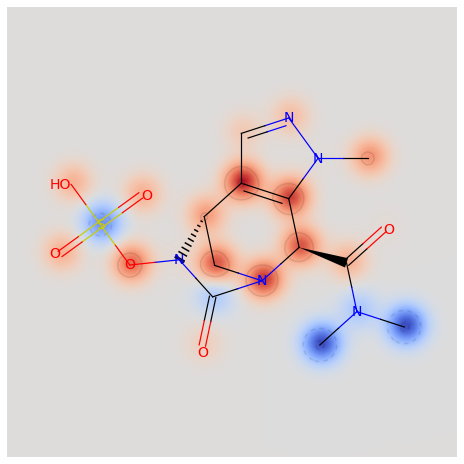

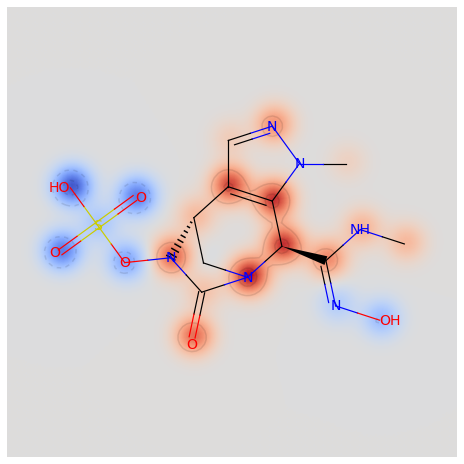

In [96]:
maps = vis_contribs(mols,df)

# Tomassi compounds
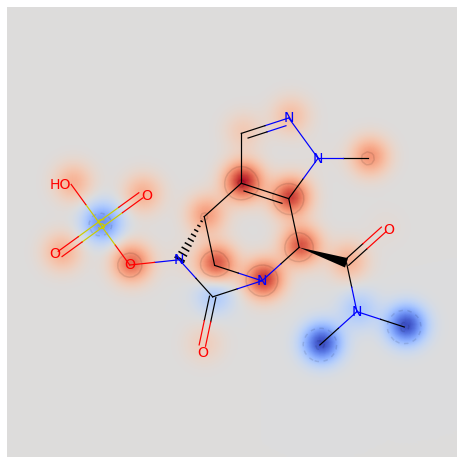

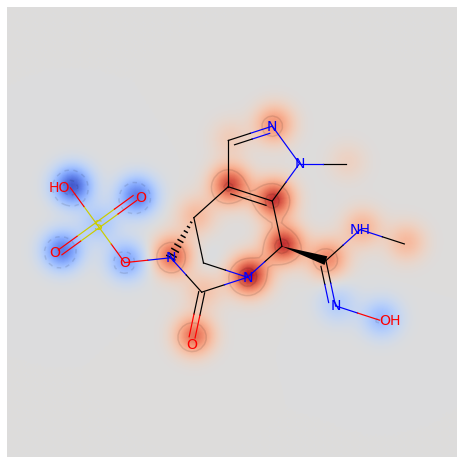
